In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, OrderedDict, Counter
from itertools import combinations
import time
import random
import csv
import math
import os
from torch.optim.lr_scheduler import _LRScheduler
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

# Configuration variables (previously args)

In [2]:
N = 256  # Block length
K = 37   # Message size
kernel_size = 16  # Kernel size (ell)
rate_profile = 'polar'  # Rate profiling; choices=['RM', 'polar', 'sorted', 'last', 'rev_polar', 'custom']
infty = 1000.  # Infinity value for frozen position LLR in polar dec
lse = 'minsum'  # LSE function; choices=['minsum', 'lse']
hard_decision = False  # Polar code sc decoding hard decision?

# DeepPolar parameters
encoder_type = 'KO'  # Type of encoding; choices=['KO', 'scaled', 'polar']
decoder_type = 'KO'  # Type of decoding; choices=['KO', 'SC', 'KO_parallel', 'KO_last_parallel']
enc_activation = 'selu'  # Activation function
dec_activation = 'selu'  # Activation function
dropout_p = 0.
dec_hidden_size = 128  # Neural network size
enc_hidden_size = 64   # Neural network size
f_depth = 3  # Decoder neural network depth
g_depth = 3  # Encoder neural network depth
g_skip_depth = 1  # Encoder neural network skip depth
g_skip_layer = 1  # Encoder neural network skip layer
onehot = False  # Use onehot representation of prev_decoded_bits
shared = False  # Share weights across depth
use_skip = True  # Use skip connections
use_norm = False  # Use normalization
binary = False  # Use binary quantization

# Infrastructure parameters
id = None  # Optional ID for multiple runs
test = False  # Testing mode flag
pairwise = False  # Plot codeword pairwise distances
epos = False  # Plot error positions
seed = None  # Random seed
anomaly = False  # Enable anomaly detection
dataparallel = False  # Use dataparallel



# Model architecture parameters
polar_depths = []  # List of depths to use polar encoding/decoding
last_ell = None  # Use kernel last_ell last layer


# Channel parameters
radar_power = None  # Radar power parameter
radar_prob = 0.1  # Radar probability parameter

# Training parameters
full_iters = 300  # Full iterations
enc_train_iters = 30  # Encoder iterations
dec_train_iters = 300  # Decoder iterations
enc_train_snr = 0.  # SNR at which encoder is trained
dec_train_snr = -2.  # SNR at which decoder is trained
weight_decay = 0.0
dec_lr = 0.001  # Decoder Learning rate
enc_lr = 0.001  # Encoder Learning rate
batch_size = 20000  # Size of batches
small_batch_size = 5000  # Size of small batches
noise_type = 'awgn'  # Noise type; choices=['fading', 'awgn', 'radar']
regularizer = None  # Regularizer type; choices=['std', 'max_deviation','polar']
regularizer_weight = 0.001
loss_type = 'BCE' # loss function; choices=['MSE', 'BCE', 'BCE_reg', 'L1', 'huber', 'focal', 'BCE_bler']
initialization = 'random'  # Initialization type; choices=['random', 'zeros']
optim_name = 'Adam'  # Optimizer type; choices=['Adam', 'RMS', 'SGD', 'AdamW']

# Testing parameters
test_batch_size = 1000  # Size of test batches
num_errors = 100  # Test until _ block errors
test_snr_start = -5.  # Testing SNR start
test_snr_end = -1.   # Testing SNR end
snr_points = 5       # Testing SNR num points



# Model saving/loading parameters
model_save_per = 100  # Model save frequency
model_iters = None  # Option to load specific model iteration
test_load_path = None  # Path to load test model

load_path = None  # Load path 
kernel_load_path = 'Polar_Results/curriculum/final_kernels/16_normal_polar_eh64_dh128_selu_new'   # Kernel load path
no_fig = False  # Plot figure option


# Scheduler parameters
scheduler = 'cosine' # choices = ['reduce', '1cycle', 'cosine']
scheduler_patience = None  # Scheduler patience
batch_schedule = False  # Use batch scheduler
batch_patience = 50  # Batch scheduler patience 
batch_factor = 2  # Batch multiplication factor
min_batch_size = 500  # Minimum batch size
max_batch_size = 50000  # Maximum batch size

# Device configuration 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
device

device(type='cuda')

In [4]:
results_save_path = f"DeepPolar_Results/attention_Polar_{kernel_size}({N},{K})/Scheme_{rate_profile}/{encoder_type}__{enc_train_snr}_Encoder_{decoder_type}_{dec_train_snr}_Decoder/epochs_{full_iters}_batchsize_{batch_size}"

In [5]:
os.makedirs(results_save_path, exist_ok=True)
os.makedirs(results_save_path +'/Models', exist_ok=True)

# Part 1: Core Utilities and Model Components 

In [6]:
def snr_db2sigma(train_snr):
    return 10**(-train_snr*1.0/20)

In [7]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [8]:
# Or a smoother version using product of bit probabilities
def soft_bler_loss(logits, targets):
    bit_probs = torch.sigmoid(logits)  # For correct bits
    bit_probs = torch.where(targets == 1., bit_probs, 1 - bit_probs)
    block_probs = torch.prod(bit_probs, dim=1)  # Probability of whole block being correct
    return -torch.mean(torch.log(block_probs + 1e-10))

In [9]:
def errors_ber(y_true, y_pred, mask=None):
    if mask == None:
        mask=torch.ones(y_true.size(),device=y_true.device)
    y_true = y_true.view(y_true.shape[0], -1, 1)
    y_pred = y_pred.view(y_pred.shape[0], -1, 1)
    mask = mask.view(mask.shape[0], -1, 1)
    myOtherTensor = (mask*torch.ne(torch.round(y_true), torch.round(y_pred))).float()
    res = sum(sum(myOtherTensor))/(torch.sum(mask))
    return res

In [10]:
def errors_bler(y_true, y_pred, get_pos = False):
    y_true = y_true.view(y_true.shape[0], -1, 1)
    y_pred = y_pred.view(y_pred.shape[0], -1, 1)

    decoded_bits = torch.round(y_pred).cpu()
    X_test = torch.round(y_true).cpu()
    tp0 = (abs(decoded_bits-X_test)).view([X_test.shape[0],X_test.shape[1]])
    tp0 = tp0.detach().cpu().numpy()
    bler_err_rate = sum(np.sum(tp0,axis=1)>0)*1.0/(X_test.shape[0])

    if not get_pos:
        return bler_err_rate
    else:
        err_pos = list(np.nonzero((np.sum(tp0,axis=1)>0).astype(int))[0])
        return bler_err_rate, err_pos


In [11]:
def corrupt_signal(input_signal, sigma = 1.0, noise_type = 'awgn', vv =5.0, radar_power = 20.0, radar_prob = 0.05):
    data_shape = input_signal.shape
    device = input_signal.device
    if noise_type == 'awgn':
        dist = torch.distributions.Normal(torch.tensor([0.0], device=device), torch.tensor([sigma], device=device))
        noise = dist.sample(input_signal.shape).squeeze()
        corrupted_signal = input_signal + noise

    elif noise_type == 'fading':
        fading_h = torch.sqrt(torch.randn_like(input_signal)**2 + torch.randn_like(input_signal)**2)/np.sqrt(3.14/2.0)
        noise = sigma * torch.randn_like(input_signal)
        corrupted_signal = fading_h *(input_signal) + noise

    elif noise_type == 'radar':
        add_pos = np.random.choice([0.0, 1.0], data_shape, p=[1 - radar_prob, radar_prob])
        corrupted_signal = radar_power* np.random.standard_normal(size=data_shape) * add_pos
        noise = sigma * torch.randn_like(input_signal) +\
                    torch.from_numpy(corrupted_signal).float().to(input_signal.device)
        corrupted_signal = input_signal + noise

    elif noise_type == 't-dist':
        dist = torch.distributions.StudentT(torch.tensor([vv], device=device))
        noise = sigma* dist.sample(input_signal.shape).squeeze()
        corrupted_signal = input_signal + noise

    return corrupted_signal

In [12]:
def min_sum_log_sum_exp(x, y):
    log_sum_ms = torch.min(torch.abs(x), torch.abs(y))*torch.sign(x)*torch.sign(y)
    return log_sum_ms

In [13]:
def min_sum_log_sum_exp_4(x_1, x_2, x_3, x_4):
    return min_sum_log_sum_exp(min_sum_log_sum_exp(x_1, x_2), min_sum_log_sum_exp(x_3, x_4))

In [14]:
def log_sum_exp(x, y):
    def log_sum_exp_(LLR_vector):
        sum_vector = LLR_vector.sum(dim=1, keepdim=True)
        sum_concat = torch.cat([sum_vector, torch.zeros_like(sum_vector)], dim=1)
        return torch.logsumexp(sum_concat, dim=1)- torch.logsumexp(LLR_vector, dim=1) 

    Lv = log_sum_exp_(torch.cat([x.unsqueeze(2), y.unsqueeze(2)], dim=2).permute(0, 2, 1))
    return Lv 


In [15]:
def dec2bitarray(in_number, bit_width):
    binary_string = bin(in_number)
    length = len(binary_string)
    bitarray = np.zeros(bit_width, 'int')
    for i in range(length-2):
        bitarray[bit_width-i-1] = int(binary_string[length-i-1])
    return bitarray

In [16]:
def countSetBits(n):
    count = 0
    while (n):
        n &= (n-1)
        count+= 1
    return count

In [17]:
class STEQuantize(torch.autograd.Function):
    @staticmethod
    def forward(ctx, inputs, enc_quantize_level = 2, enc_value_limit = 1.0, enc_grad_limit = 0.01, enc_clipping = 'both'):
        ctx.save_for_backward(inputs)
        assert enc_clipping in ['both', 'inputs']
        ctx.enc_clipping = enc_clipping
        ctx.enc_value_limit = enc_value_limit
        ctx.enc_quantize_level = enc_quantize_level
        ctx.enc_grad_limit = enc_grad_limit

        x_lim_abs = enc_value_limit
        x_lim_range = 2.0 * x_lim_abs
        x_input_norm = torch.clamp(inputs, -x_lim_abs, x_lim_abs)

        if enc_quantize_level == 2:
            outputs_int = torch.sign(x_input_norm)
        else:
            outputs_int = torch.round((x_input_norm +x_lim_abs) * ((enc_quantize_level - 1.0)/x_lim_range)) * x_lim_range/(enc_quantize_level - 1.0) - x_lim_abs

        return outputs_int

    @staticmethod
    def backward(ctx, grad_output):
        if ctx.enc_clipping in ['inputs', 'both']:
            input, = ctx.saved_tensors
            grad_output[input>ctx.enc_value_limit]=0
            grad_output[input<-ctx.enc_value_limit]=0

        if ctx.enc_clipping in ['gradient', 'both']:
            grad_output = torch.clamp(grad_output, -ctx.enc_grad_limit, ctx.enc_grad_limit)
        grad_input = grad_output.clone()

        return grad_input, None

In [18]:
def get_activation_fn(activation):
    if activation == 'tanh':
        return F.tanh
    elif activation == 'elu':
        return F.elu
    elif activation == 'relu':
        return F.relu
    elif activation == 'selu':
        return F.selu
    elif activation == 'sigmoid':
        return F.sigmoid
    elif activation == 'gelu':
        return F.gelu
    elif activation == 'silu':
        return F.silu
    elif activation == 'mish':
        return F.mish
    elif activation == 'linear':
        return nn.Identity()
    else:
        raise NotImplementedError(f'Activation function {activation} not implemented')


In [19]:
class g_Full(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, depth=3, skip_depth=1, skip_layer=1, ell=2, activation='selu', use_skip=False, augment=False):
        super(g_Full, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.depth = depth
        self.ell = ell
        self.ell_input_size = input_size//self.ell
        self.augment = augment
        self.activation_fn = get_activation_fn(activation)
        self.skip_depth = skip_depth
        self.skip_layer = skip_layer
        self.use_skip = use_skip

        if self.use_skip:
            self.skip = nn.ModuleList([nn.Linear(self.input_size + self.output_size, self.hidden_size, bias=True)])
            self.skip.extend([nn.Linear(self.hidden_size, self.hidden_size, bias=True) for ii in range(1, self.skip_depth)])

        self.linears = nn.ModuleList([nn.Linear(self.input_size, self.hidden_size, bias=True)])
        self.linears.extend([nn.Linear(self.hidden_size, self.hidden_size, bias=True) for ii in range(1, self.depth)])
        self.linears.append(nn.Linear(self.hidden_size, self.output_size, bias=True))

    @staticmethod
    def get_augment(msg, ell):
        u = msg.clone()
        n = int(np.log2(ell))
        for d in range(0, n):
            num_bits = 2**d
            for i in np.arange(0, ell, 2*num_bits):
                if len(u.shape) == 2:
                    u = torch.cat((u[:, :i], u[:, i:i+num_bits].clone() * u[:, i+num_bits: i+2*num_bits], u[:, i+num_bits:]), dim=1)
                elif len(u.shape) == 3:
                    u = torch.cat((u[:, :, :i], u[:, :, i:i+num_bits].clone() * u[:, :, i+num_bits: i+2*num_bits], u[:, :, i+num_bits:]), dim=2)

        if len(u.shape) == 3:
            return u[:, :, :-1]
        elif len(u.shape) == 2:
            return u[:, :-1]

    def forward(self, y):
        x = y.clone()
        for ii, layer in enumerate(self.linears):
            if ii != self.depth:
                x = self.activation_fn(layer(x))
                if self.use_skip and ii == self.skip_layer:
                    if len(x.shape) == 3:
                        skip_input = torch.cat([y, g_Full.get_augment(y, self.ell)], dim=2)
                    elif len(x.shape) == 2:
                        skip_input = torch.cat([y, g_Full.get_augment(y, self.ell)], dim=1)
                    for jj, skip_layer in enumerate(self.skip):
                        skip_input = self.activation_fn(skip_layer(skip_input))
                    x = x + skip_input
            else:
                x = layer(x)
                if self.augment:
                    x = x + g_Full.get_augment(y, self.ell)
        return x

In [20]:
class SelfAttentionLayer(nn.Module):
    def __init__(self, hidden_dim, num_heads=8, dropout=0.1):
        super().__init__()
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x shape should be: (batch_size, seq_len, hidden_dim)
        attn_out, _ = self.attention(x, x, x)
        attn_out = self.dropout(attn_out)
        return self.norm(x + attn_out)

class f_Full(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_p=0., activation='selu', depth=3, use_norm=False):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.depth = depth
        self.use_norm = use_norm
        self.activation_fn = get_activation_fn(activation)

        # Initial layers same as original f_Full
        self.linears = nn.ModuleList([nn.Linear(self.input_size, self.hidden_size, bias=True)])
        if self.use_norm:
            self.norms = nn.ModuleList([nn.LayerNorm(self.hidden_size)])
        
        # Attention layer after first linear
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=4,  # Reduced number of heads
            dropout=dropout_p,
            batch_first=True
        )
        
        # Remaining layers same as original
        for ii in range(1, self.depth):
            self.linears.append(nn.Linear(self.hidden_size, self.hidden_size, bias=True))
            if self.use_norm:
                self.norms.append(nn.LayerNorm(self.hidden_size))
        self.linears.append(nn.Linear(self.hidden_size, self.output_size, bias=True))

    def forward(self, y, aug=None):
        x = y.clone()
        
        # First linear layer
        x = self.linears[0](x)
        if self.use_norm:
            x = self.norms[0](x)
        x = self.activation_fn(x)
        
        # Apply attention
        # Reshape for attention: [batch, seq_len, hidden]
        if len(x.shape) == 2:
            x = x.unsqueeze(1)
        attn_out, _ = self.attention(x, x, x)
        x = attn_out if len(y.shape) == 3 else attn_out.squeeze(1)
        
        # Remaining layers
        for ii in range(1, len(self.linears)):
            if ii != self.depth:
                x = self.linears[ii](x)
                if self.use_norm:
                    x = self.norms[ii](x)
                x = self.activation_fn(x)
            else:
                x = self.linears[ii](x)
        return x

In [21]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.0, 0.01)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.01)
        try:
            m.bias.data.fill_(0.)
        except:
            pass

In [22]:
def get_onehot(actions):
    inds = (0.5 + 0.5*actions).long()
    return torch.eye(2, device = inds.device)[inds].reshape(actions.shape[0], -1)

# Part 2: Core PolarCode Class

In [23]:
class PolarCode:

    def __init__(self, n, K, Fr = None, rs = None, use_cuda = True, infty = 1000., hard_decision = False, lse = 'lse'):

        assert n>=1
        self.n = n
        self.N = 2**n
        self.K = K
        self.G2 = np.array([[1,1],[0,1]])
        self.G = np.array([1])
        for i in range(n):
            self.G = np.kron(self.G, self.G2)
        self.G = torch.from_numpy(self.G).float()
        self.device = torch.device("cuda" if use_cuda else "cpu")
        self.infty = infty
        self.hard_decision = hard_decision
        self.lse = lse

        if Fr is not None:
            assert len(Fr) == self.N - self.K
            self.frozen_positions = Fr
            self.unsorted_frozen_positions = self.frozen_positions
            self.frozen_positions.sort()

            self.info_positions = np.array(list(set(self.frozen_positions) ^ set(np.arange(self.N))))
            self.unsorted_info_positions = self.info_positions
            self.info_positions.sort()
            
        else:
            if rs is None:
                # in increasing order of reliability
                self.reliability_seq = np.arange(1023, -1, -1)
                self.rs = self.reliability_seq[self.reliability_seq<self.N]
            else:
                self.reliability_seq = rs
                self.rs = self.reliability_seq[self.reliability_seq<self.N]

                assert len(self.rs) == self.N
            # best K bits
            self.info_positions = self.rs[:self.K]
            self.unsorted_info_positions = self.reliability_seq[self.reliability_seq<self.N][:self.K]
            self.info_positions.sort()
            self.unsorted_info_positions=np.flip(self.unsorted_info_positions)
            # worst N-K bits
            self.frozen_positions = self.rs[self.K:]
            self.unsorted_frozen_positions = self.rs[self.K:]
            self.frozen_positions.sort()


            self.CRC_polynomials = {
            3: torch.Tensor([1, 0, 1, 1]).int(),
            8: torch.Tensor([1, 1, 1, 0, 1, 0, 1, 0, 1]).int(),
            16: torch.Tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]).int(),
                                    }

    def get_G(self, ell):
        n = int(np.log2(ell))
        G = np.array([1])
        for i in range(n):
            G = np.kron(G, self.G2)
        return G

    def encode_plotkin(self, message, scaling = None, custom_info_positions = None):

        # message shape is (batch, k)
        # BPSK convention : 0 -> +1, 1 -> -1
        # Therefore, xor(a, b) = a*b
        if custom_info_positions is not None:
            info_positions = custom_info_positions
        else:
            info_positions = self.info_positions
        u = torch.ones(message.shape[0], self.N, dtype=torch.float).to(message.device)
        u[:, info_positions] = message

        for d in range(0, self.n):
            num_bits = 2**d
            for i in np.arange(0, self.N, 2*num_bits):
                # [u v] encoded to [u xor(u,v)]
                u = torch.cat((u[:, :i], u[:, i:i+num_bits].clone() * u[:, i+num_bits: i+2*num_bits], u[:, i+num_bits:]), dim=1)
                # u[:, i:i+num_bits] = u[:, i:i+num_bits].clone() * u[:, i+num_bits: i+2*num_bits].clone
        if scaling is not None:
            u = (scaling * np.sqrt(self.N)*u)/torch.norm(scaling)
        return u
    
    def channel(self, code, snr, noise_type = 'awgn', vv =5.0, radar_power = 20.0, radar_prob = 5e-2):
        if noise_type != "bsc":
            sigma = snr_db2sigma(snr)
        else:
            sigma = snr

        r = corrupt_signal(code, sigma, noise_type, vv, radar_power, radar_prob)

        return r

    def define_partial_arrays(self, llrs):
        # Initialize arrays to store llrs and partial_sums useful to compute the partial successive cancellation process.
        llr_array = torch.zeros(llrs.shape[0], self.n+1, self.N, device=llrs.device)
        llr_array[:, self.n] = llrs
        partial_sums = torch.zeros(llrs.shape[0], self.n+1, self.N, device=llrs.device)
        return llr_array, partial_sums


    def updateLLR(self, leaf_position, llrs, partial_llrs = None, prior = None):

        #START
        depth = self.n
        decoded_bits = partial_llrs[:,0].clone()
        if prior is None:
            prior = torch.zeros(self.N) #priors
        llrs, partial_llrs, decoded_bits = self.partial_decode(llrs, partial_llrs, depth, 0, leaf_position, prior, decoded_bits)
        return llrs, decoded_bits

    
    

    def partial_decode(self, llrs, partial_llrs, depth, bit_position, leaf_position, prior, decoded_bits=None):
        # Function to call recursively, for partial SC decoder.
        # We are assuming that u_0, u_1, .... , u_{leaf_position -1} bits are known.
        # Partial sums computes the sums got through Plotkin encoding operations of known bits, to avoid recomputation.
        # this function is implemented for rate 1 (not accounting for frozen bits in polar SC decoding)

        # print("DEPTH = {}, bit_position = {}".format(depth, bit_position))
        half_index = 2 ** (depth - 1)
        leaf_position_at_depth = leaf_position // 2**(depth-1) # will tell us whether left_child or right_child

        # n = 2 tree case
        if depth == 1:
            # Left child
            left_bit_position = 2*bit_position
            if leaf_position_at_depth > left_bit_position:
                u_hat = partial_llrs[:, depth-1, left_bit_position:left_bit_position+1]
            elif leaf_position_at_depth == left_bit_position:
                if self.lse == 'minsum':
                    Lu = min_sum_log_sum_exp(llrs[:, depth, left_bit_position*half_index:(left_bit_position+1)*half_index], llrs[:,depth, (left_bit_position+1)*half_index:(left_bit_position+2)*half_index]).sum(dim=1, keepdim=True)
                elif self.lse == 'lse':
                    Lu = log_sum_exp(llrs[:, depth, left_bit_position*half_index:(left_bit_position+1)*half_index], llrs[:,depth, (left_bit_position+1)*half_index:(left_bit_position+2)*half_index]).sum(dim=1, keepdim=True)
                # Lu = log_sum_avoid_zero_NaN(llrs[:, depth, left_bit_position*half_index:(left_bit_position+1)*half_index], llrs[:,depth, (left_bit_position+1)*half_index:(left_bit_position+2)*half_index]).sum(dim=1, keepdim=True)
                #print(Lu.device, prior.device, torch.ones_like(Lu).device)
                llrs[:, depth-1, left_bit_position*half_index:(left_bit_position+1)*half_index] = Lu + prior[left_bit_position]*torch.ones_like(Lu)
                if self.hard_decision:
                    u_hat = torch.sign(Lu)
                else:
                    u_hat = torch.tanh(Lu/2)

                decoded_bits[:, left_bit_position] = u_hat.squeeze(1)

                return llrs, partial_llrs, decoded_bits

            # Right child
            right_bit_position = 2*bit_position + 1
            if leaf_position_at_depth > right_bit_position:
                pass
            elif leaf_position_at_depth == right_bit_position:
                Lv = u_hat * llrs[:, depth, left_bit_position*half_index:(left_bit_position+1)*half_index] + llrs[:,depth, (left_bit_position+1)*half_index:(left_bit_position+2)*half_index]
                llrs[:, depth-1, right_bit_position*half_index:(right_bit_position+1)*half_index] = Lv + prior[right_bit_position] * torch.ones_like(Lv)
                if self.hard_decision:
                    v_hat = torch.sign(Lv)
                else:
                    v_hat = torch.tanh(Lv/2)
                decoded_bits[:, right_bit_position] = v_hat.squeeze(1)
                return llrs, partial_llrs, decoded_bits

        # General case
        else:
            # LEFT CHILD
            # Find likelihood of (u xor v) xor (v) = u
            # Lu = log_sum_exp(torch.cat([llrs[:, :half_index].unsqueeze(2), llrs[:, half_index:].unsqueeze(2)], dim=2).permute(0, 2, 1))

            left_bit_position = 2*bit_position
            if leaf_position_at_depth > left_bit_position:
                Lu = llrs[:, depth-1, left_bit_position*half_index:(left_bit_position+1)*half_index]
                u_hat = partial_llrs[:, depth-1, left_bit_position*half_index:(left_bit_position+1)*half_index]
            else:
                if self.lse == 'minsum':
                    Lu = min_sum_log_sum_exp(llrs[:, depth, left_bit_position*half_index:(left_bit_position+1)*half_index], llrs[:,depth, (left_bit_position+1)*half_index:(left_bit_position+2)*half_index])
                elif self.lse == 'lse':
                    # Lu = log_sum_avoid_zero_NaN(llrs[:, depth, left_bit_position*half_index:(left_bit_position+1)*half_index], llrs[:,depth, (left_bit_position+1)*half_index:(left_bit_position+2)*half_index])
                    Lu = log_sum_exp(llrs[:, depth, left_bit_position*half_index:(left_bit_position+1)*half_index], llrs[:,depth, (left_bit_position+1)*half_index:(left_bit_position+2)*half_index])

                llrs[:, depth-1, left_bit_position*half_index:(left_bit_position+1)*half_index] = Lu
                llrs, partial_llrs, decoded_bits = self.partial_decode(llrs, partial_llrs, depth-1, left_bit_position, leaf_position, prior, decoded_bits)

                return llrs, partial_llrs, decoded_bits

            # RIGHT CHILD
            right_bit_position = 2*bit_position + 1

            Lv = u_hat * llrs[:, depth, left_bit_position*half_index:(left_bit_position+1)*half_index] + llrs[:,depth, (left_bit_position+1)*half_index:(left_bit_position+2)*half_index]
            llrs[:, depth-1, right_bit_position*half_index:(right_bit_position+1)*half_index] = Lv
            llrs, partial_llrs, decoded_bits = self.partial_decode(llrs, partial_llrs, depth-1, right_bit_position, leaf_position, prior, decoded_bits)

            return llrs, partial_llrs, decoded_bits

    def updatePartialSums(self, leaf_position, decoded_bits, partial_llrs):

        u = decoded_bits.clone()
        u[:, leaf_position+1:] = 0

        for d in range(0, self.n):
            partial_llrs[:, d] = u
            num_bits = 2**d
            for i in np.arange(0, self.N, 2*num_bits):
                # [u v] encoded to [u xor(u,v)]
                u = torch.cat((u[:, :i], u[:, i:i+num_bits].clone() * u[:, i+num_bits: i+2*num_bits], u[:, i+num_bits:]), dim=1)
        partial_llrs[:, self.n] = u
        return partial_llrs

    def sc_decode_new(self, corrupted_codewords, snr, use_gt = None, channel = 'awgn'):

        assert channel in ['awgn', 'bsc']

        if channel == 'awgn':
            noise_sigma = snr_db2sigma(snr)
            llrs = (2/noise_sigma**2)*corrupted_codewords
        elif channel == 'bsc':
            # snr refers to transition prob
            p = (torch.ones(1)*(snr + 1e-9)).to(corrupted_codewords.device)
            llrs = (torch.clip(torch.log((1 - p) / p), -10000, 10000) * (corrupted_codewords + 1) - torch.clip(torch.log(p / (1-p)), -10000, 10000) * (corrupted_codewords - 1))/2

        # step-wise implementation using updateLLR and updatePartialSums

        priors = torch.zeros(self.N)
        priors[self.frozen_positions] = self.infty

        u_hat = torch.zeros(corrupted_codewords.shape[0], self.N, device=corrupted_codewords.device)
        llr_array, partial_llrs = self.define_partial_arrays(llrs)
        for ii in range(self.N):
            #start = time.time()
            llr_array , decoded_bits = self.updateLLR(ii, llr_array.clone(), partial_llrs, priors)
            #print('SC update : {}'.format(time.time() - start), corrupted_codewords.shape[0])
            if use_gt is None:
                u_hat[:, ii] = torch.sign(llr_array[:, 0, ii])
            else:
                u_hat[:, ii] = use_gt[:, ii]
            #start = time.time()
            partial_llrs = self.updatePartialSums(ii, u_hat, partial_llrs)
            #print('SC partial: {}s, {}', time.time() - start, 'frozen' if ii in self.frozen_positions else 'info')
        decoded_bits = u_hat[:, self.info_positions]
        return llr_array[:, 0, :].clone(), decoded_bits

    def get_CRC(self, message):

        # need to optimize.
        # inout message should be int

        padded_bits = torch.cat([message, torch.zeros(self.CRC_len).int().to(message.device)])
        while len(padded_bits[0:self.K_minus_CRC].nonzero()):
            cur_shift = (padded_bits != 0).int().argmax(0)
            padded_bits[cur_shift: cur_shift + self.CRC_len + 1] = padded_bits[cur_shift: cur_shift + self.CRC_len + 1] ^ self.CRC_polynomials[self.CRC_len].to(message.device)

        return padded_bits[self.K_minus_CRC:]

    def CRC_check(self, message):

        # need to optimize.
        # input message should be int

        padded_bits = message
        while len(padded_bits[0:self.K_minus_CRC].nonzero()):
            cur_shift = (padded_bits != 0).int().argmax(0)
            padded_bits[cur_shift: cur_shift + polar.CRC_len + 1] ^= self.CRC_polynomials[self.CRC_len].to(message.device)

        if padded_bits[self.K_minus_CRC:].sum()>0:
            return 0
        else:
            return 1

    def encode_with_crc(self, message, CRC_len):
        self.CRC_len = CRC_len
        self.K_minus_CRC = self.K - CRC_len

        if CRC_len == 0:
            return self.encode_plotkin(message)
        else:
            crcs = 1-2*torch.vstack([self.get_CRC((0.5+0.5*message[jj]).int()) for jj in range(message.shape[0])])
            encoded = self.encode_plotkin(torch.cat([message, crcs], 1))

            return encoded

# Part 3: DeepPolar Class and Training Functions

In [24]:
class DeepPolar(PolarCode):
    def __init__(self, device, N, K, ell = 2, infty = 1000., depth_map : defaultdict = None):

        # rmweight = np.array([countSetBits(i) for i in range(N)])
        # Frozen = np.argsort(rmweight)[:-K]
        # Frozen.sort()

        #self.args = args
        Fr = get_frozen(N, K, rate_profile)
        super().__init__(n = int(np.log2(N)), K = K, Fr=Fr,  infty = infty)
        self.N = N

        if depth_map is not None:
            # depth map is a dict, product of values should be equal to N
            assert np.prod(list(depth_map.values())) == N
            # assert that keys od depth map start from one and go continuosly till some point 
            assert min(list(depth_map.keys())) == 1
            assert max(list(depth_map.keys())) <= int(np.log2(N))
            self.ell = None
            self.n_ell = len(depth_map.keys())
            assert max(list(depth_map.keys())) == self.n_ell

            self.depth_map = depth_map
        else:
            self.ell = ell
            self.n_ell = int(np.log(N)/np.log(self.ell))

            self.depth_map = defaultdict(int)
            for d in range(1, self.n_ell+1):
                self.depth_map[d] = self.ell
            assert np.prod(list(self.depth_map.values())) == N

        self.device = device
        self.fnet_dict = None
        self.gnet_dict = None

        self.infty = infty

    @staticmethod
    def get_onehot(actions):
        inds = (0.5 + 0.5*actions).long()
        if len(actions.shape) == 2:
            return torch.eye(2, device = inds.device)[inds].reshape(actions.shape[0], -1)
        elif len(actions.shape) == 3:
            return torch.eye(2, device = inds.device)[inds].reshape(actions.shape[0], actions.shape[1], -1)

    def define_kernel_nns(self, ell, unfrozen = None, fnet = 'KO', gnet = 'KO', shared = False):

        if 'KO' in fnet:
            self.fnet_dict = {}
        else:
            self.fnet_dict = None

        self.shared = shared
        if 'KO' in gnet:
            self.gnet_dict = {}
        else:
            self.gnet_dict = None
        #dec_hidden_size = dec_hidden_size
        #enc_hidden_size = enc_hidden_size

        depth = 1
        assert len(unfrozen) > 0, "No unfrozen bits!"

        self.fnet_dict[depth] = {}

        if fnet == 'KO_parallel' or fnet == 'KO_last_parallel':
            bit_position = 0
                   
            self.fnet_dict[depth][bit_position] = {}
            # input_size = self.N if depth == self.n_ell else self.N // int(np.prod([self.depth_map[d] for d in range(depth+1, self.n_ell+1)]))
            input_size = ell             
            # For curriculum, only for lowest depth.
            output_size = ell#len(unfrozen)
            self.fnet_dict[depth][bit_position] = f_Full(input_size, dec_hidden_size, output_size, activation = dec_activation, dropout_p = dropout_p, depth = f_depth, use_norm = use_norm).to(self.device)
 
        elif 'KO' in fnet:
            if shared:
                self.fnet_dict[depth] = {}
                for current_position in range(ell):
                    self.fnet_dict[depth][current_position] = f_Full(ell + current_position, dec_hidden_size, 1, activation = dec_activation, dropout_p = dropout_p, depth = f_depth, use_norm = use_norm).to(self.device)
            else:
                bit_position = 0
                for current_position in unfrozen:
                    if not self.fnet_dict[depth].get(bit_position):
                        self.fnet_dict[depth][bit_position] = {}
                    input_size = ell + (int(onehot)+1)*current_position
                    self.fnet_dict[depth][bit_position][current_position] = f_Full(input_size, dec_hidden_size, 1, activation = dec_activation, dropout_p = dropout_p, depth = f_depth, use_norm = use_norm).to(self.device)
                
        if 'KO' in gnet:
            self.gnet_dict[depth] = {}
            if shared:
                if gnet == 'KO':
                    self.gnet_dict[depth] = g_Full(ell, enc_hidden_size, ell-1, depth = g_depth, skip_depth = g_skip_depth, skip_layer = g_skip_layer, ell = ell, activation = enc_activation, use_skip = use_skip).to(self.device)
            else:
                bit_position = 0
                if gnet == 'KO':
                    self.gnet_dict[depth][bit_position] = g_Full(ell, enc_hidden_size, ell-1, depth = g_depth, skip_depth = g_skip_depth, skip_layer = g_skip_layer, ell = ell, activation = enc_activation, use_skip = use_skip).to(self.device)

    def define_and_load_nns(self, ell, kernel_load_path=None, fnet='KO', gnet='KO', shared=True, dataparallel=False):
        # Initialize decoder and encoder dictionaries
        if 'KO' in fnet:
            self.fnet_dict = {}
        else:
            self.fnet_dict = None

        self.shared = shared

        if 'KO' in gnet:
            self.gnet_dict = {}
        else:
            self.gnet_dict = None

        # Loop through each depth level
        for depth in range(self.n_ell, 0, -1):
            if depth in polar_depths:
                continue

            ell = self.depth_map[depth]
            proj_size = np.prod([self.depth_map[d] for d in range(1, depth+1)])

            # Handle parallel decoder case
            if fnet == 'KO_last_parallel' and depth == 1:
                self.fnet_dict[depth] = {}
                for bit_position in range(self.N // proj_size):
                    proj = np.arange(bit_position*proj_size, (bit_position+1)*proj_size)
                    get_num_info_proj = lambda proj : sum([int(x in self.info_positions) for x in proj])
                    num_info_in_proj = get_num_info_proj(proj)

                    subproj_len = len(proj) // ell
                    subproj = [proj[i:i+subproj_len] for i in range(0, len(proj), subproj_len)]
                    num_info_in_subproj = [get_num_info_proj(x) for x in subproj]
                    unfrozen = [i for i, x in enumerate(num_info_in_subproj) if x >= 1]

                    input_size = ell             
                    output_size = ell

                    # Use attention-enhanced decoder for parallel case
                    self.fnet_dict[depth][bit_position] = f_Full(
                        input_size=input_size,
                        hidden_size=dec_hidden_size,
                        output_size=output_size,
                        activation=dec_activation,
                        dropout_p=dropout_p,
                        depth=f_depth,
                        use_norm=use_norm
                    ).to(self.device)

                    # Load pretrained weights if available
                    if len(unfrozen) > 0 and kernel_load_path is not None:
                        try:
                            ckpt = torch.load(os.path.join(kernel_load_path + '_parallel', f'{ell}_{len(unfrozen)}.pt'))
                            self.fnet_dict[depth][bit_position].load_state_dict(ckpt[0][1][0].state_dict())
                        except FileNotFoundError:
                            print(f"Parallel File not found for ell = {ell}, num_unfrozen = {len(unfrozen)}")
                            pass

                    if dataparallel:
                        self.fnet_dict[depth][bit_position] = nn.DataParallel(self.fnet_dict[depth][bit_position])

            # Handle sequential decoder case
            elif 'KO' in fnet:
                self.fnet_dict[depth] = {}

                if shared:
                    # Shared decoder network for all positions
                    for current_position in range(ell):
                        self.fnet_dict[depth][current_position] = f_Full(
                            input_size=ell + current_position,
                            hidden_size=dec_hidden_size,
                            output_size=1,
                            activation=dec_activation,
                            dropout_p=dropout_p,
                            depth=f_depth,
                            use_norm=use_norm
                        ).to(self.device)

                        if dataparallel:
                            self.fnet_dict[depth][current_position] = nn.DataParallel(self.fnet_dict[depth][current_position])

                else:
                    # Individual decoder networks for each position
                    for bit_position in range(self.N // proj_size):
                        proj = np.arange(bit_position*proj_size, (bit_position+1)*proj_size)
                        get_num_info_proj = lambda proj : sum([int(x in self.info_positions) for x in proj])
                        num_info_in_proj = get_num_info_proj(proj)

                        subproj_len = len(proj) // ell
                        subproj = [proj[i:i+subproj_len] for i in range(0, len(proj), subproj_len)]
                        num_info_in_subproj = [get_num_info_proj(x) for x in subproj]
                        unfrozen = [i for i, x in enumerate(num_info_in_subproj) if x >= 1]

                        # Load pretrained weights if available
                        ckpt_exists = False
                        if len(unfrozen) > 0 and kernel_load_path is not None:
                            try:
                                ckpt = torch.load(os.path.join(kernel_load_path, f'{ell}_{len(unfrozen)}.pt'))
                                ckpt_exists = True
                            except FileNotFoundError:
                                print(f"File not found for ell = {ell}, num_unfrozen = {len(unfrozen)}")
                                pass

                        # Create decoders for unfrozen positions
                        for current_position in unfrozen:
                            if not self.fnet_dict[depth].get(bit_position):
                                self.fnet_dict[depth][bit_position] = {}

                            input_size = ell + (int(onehot)+1)*current_position
                            output_size = 1

                            self.fnet_dict[depth][bit_position][current_position] = f_Full(
                                input_size=input_size,
                                hidden_size=dec_hidden_size,
                                output_size=output_size,
                                activation=dec_activation,
                                dropout_p=dropout_p,
                                depth=f_depth,
                                use_norm=use_norm
                            ).to(self.device)

                            if ckpt_exists:
                                try:
                                    f_ckpt = ckpt[0][1][0][current_position].state_dict()
                                    self.fnet_dict[depth][bit_position][current_position].load_state_dict(f_ckpt)
                                except:
                                    print(f"Warning: Could not load weights for position {current_position}")

                            if dataparallel:
                                self.fnet_dict[depth][bit_position][current_position] = nn.DataParallel(
                                    self.fnet_dict[depth][bit_position][current_position]
                                )

            # Handle encoder network
            if 'KO' in gnet:
                self.gnet_dict[depth] = {}
                if shared:
                    if gnet == 'KO':
                        if not dataparallel:
                            self.gnet_dict[depth] = g_Full(
                                ell, enc_hidden_size, ell-1,
                                depth=g_depth,
                                skip_depth=g_skip_depth,
                                skip_layer=g_skip_layer,
                                ell=ell,
                                use_skip=use_skip
                            ).to(self.device)
                        else:
                            self.gnet_dict[depth] = nn.DataParallel(
                                g_Full(
                                    ell, enc_hidden_size, ell-1,
                                    depth=g_depth,
                                    skip_depth=g_skip_depth,
                                    skip_layer=g_skip_layer,
                                    ell=ell,
                                    use_skip=use_skip
                                )
                            ).to(self.device)
                else:
                    for bit_position in range(self.N // proj_size):
                        proj = np.arange(bit_position*proj_size, (bit_position+1)*proj_size)
                        num_info_in_proj = sum([int(x in self.info_positions) for x in proj])

                        if num_info_in_proj > 0:
                            if gnet == 'KO':
                                self.gnet_dict[depth][bit_position] = g_Full(
                                    ell, enc_hidden_size, ell-1,
                                    depth=g_depth,
                                    skip_depth=g_skip_depth,
                                    skip_layer=g_skip_layer,
                                    ell=ell,
                                    activation=enc_activation,
                                    use_skip=use_skip
                                ).to(self.device)

                            # Load pretrained weights if available
                            if kernel_load_path is not None:
                                try:
                                    ckpt = torch.load(os.path.join(kernel_load_path, f'{ell}_{len(unfrozen)}.pt'))
                                    self.gnet_dict[depth][bit_position].load_state_dict(ckpt[1][1][0].state_dict())
                                except FileNotFoundError:
                                    print(f"File not found for ell = {ell}, num_unfrozen = {len(unfrozen)}")
                                    pass

                            if dataparallel:
                                self.gnet_dict[depth][bit_position] = nn.DataParallel(self.gnet_dict[depth][bit_position])

        if kernel_load_path is not None:
            print("Loaded kernel from ", kernel_load_path)

    def load_nns(self, fnet_dict, gnet_dict = None, shared = False):
        self.fnet_dict = fnet_dict
        self.gnet_dict = gnet_dict

        for depth in fnet_dict.keys():
            if self.fnet_dict is not None:
                for bit_position in self.fnet_dict[depth].keys():
                    if not isinstance(self.fnet_dict[depth][bit_position], dict):#shared or decoder_type == 'KO_parallel' or decoder_type == 'KO_RNN':
                        self.fnet_dict[depth][bit_position].to(self.device)
                    else:
                        for current_position in self.fnet_dict[depth][bit_position].keys():
                            self.fnet_dict[depth][bit_position][current_position].to(self.device)
            if gnet_dict is not None:
                if shared:
                    self.gnet_dict[depth].to(self.device)
                else:
                    for bit_position in self.gnet_dict[depth].keys():
                        self.gnet_dict[depth][bit_position].to(self.device)
        print("NN weights loaded!")

    def load_partial_nns(self, fnet_dict, gnet_dict = None):

        for depth in fnet_dict.keys():
            if fnet_dict is not None:
                for bit_position in fnet_dict[depth].keys():
                    if isinstance(fnet_dict[depth][bit_position], dict):
                        for current_position in fnet_dict[depth][bit_position].keys():
                            self.fnet_dict[depth][bit_position][current_position] = fnet_dict[depth][bit_position][current_position].to(self.device)
                    else:
                        self.fnet_dict[depth][bit_position] = fnet_dict[depth][bit_position].to(self.device)

            if gnet_dict is not None:
                for bit_position in gnet_dict[depth].keys():
                    self.gnet_dict[depth][bit_position] = gnet_dict[depth][bit_position].to(self.device)
        print("NN weights loaded!")

    def kernel_encode(self, ell, gnet, msg_bits, info_positions, binary = False):
        input_shape = msg_bits.shape[-1]
        assert input_shape <= ell
        u = torch.ones(msg_bits.shape[0], self.N, dtype=torch.float).to(self.device)
        u[:, info_positions] = msg_bits
        output =torch.cat([gnet(u.unsqueeze(1)).squeeze(1), u[:, -1:]], 1)

        power_constrained_u = self.power_constraint(output)
        if binary:
            stequantize = STEQuantize.apply
            power_constrained_u = stequantize(power_constrained_u)
        return power_constrained_u

    def deeppolar_encode(self, msg_bits, binary = False):
        u = torch.ones(msg_bits.shape[0], self.N, dtype=torch.float).to(self.device)
        u[:, self.info_positions] = msg_bits
        for d in range(1, self.n_ell+1):
            # num_bits = self.ell**(d-1)
            num_bits = np.prod([self.depth_map[dd] for dd in range(1, d)]) if d > 1 else 1
            # proj_size = self.ell**(d)
            proj_size = np.prod([self.depth_map[dd] for dd in range(1, d+1)])
            ell = self.depth_map[d]
            for bit_position, i in enumerate(np.arange(0, self.N, ell*num_bits)):

                # [u v] encoded to [(u xor v),v)]
                proj = np.arange(bit_position*proj_size, (bit_position+1)*proj_size)
                get_num_info_proj = lambda proj : sum([int(x in self.info_positions) for x in proj])
                num_info_in_proj = get_num_info_proj(proj)

                subproj_len = len(proj) // ell
                subproj = [proj[i:i+subproj_len] for i in range(0, len(proj), subproj_len)]
                num_info_in_subproj = [get_num_info_proj(x) for x in subproj]
                num_nonzero_subproj = sum([int(x != 0) for x in num_info_in_subproj])
                
                if num_info_in_proj > 0:
                    info_bits_present = True          
                else:
                    info_bits_present = False         
                if d in polar_depths:
                    info_bits_present = False

                enc_chunks = []
                ell = self.depth_map[d]
                for j in range(ell):
                    chunk = u[:, i + j*num_bits:i + (j+1)*num_bits].unsqueeze(2).clone()
                    enc_chunks.append(chunk)
                if info_bits_present:
                    concatenated_chunks = torch.cat(enc_chunks, 2)
                    if self.shared:
                        output = torch.cat([self.gnet_dict[d](concatenated_chunks), u[:, i + (ell-1)*num_bits:i + (ell)*num_bits].unsqueeze(2)], dim=2)
                    else:
                        output = torch.cat([self.gnet_dict[d][bit_position](concatenated_chunks), u[:, i + (ell-1)*num_bits:i + (ell)*num_bits].unsqueeze(2)], dim=2)
                    output = output.permute(0,2,1).reshape(msg_bits.shape[0], -1, 1).squeeze(2)

                else:
                    output = self.encode_chunks_plotkin(enc_chunks, ell)
                u = torch.cat((u[:, :i], output, u[:, i + ell*num_bits:]), dim=1)

        power_constrained_u = self.power_constraint(u)
        if binary:
            stequantize = STEQuantize.apply
            power_constrained_u = stequantize(power_constrained_u)
        return power_constrained_u

    def power_constraint(self, codewords):
        return F.normalize(codewords, p=2, dim=1)*np.sqrt(self.N)

    def encode_chunks_plotkin(self, enc_chunks, ell = None):

        # message shape is (batch, k)
        # BPSK convention : 0 -> +1, 1 -> -1
        # Therefore, xor(a, b) = a*b

        # to change for other kernels

        if ell is None:
            ell = self.ell
        assert len(enc_chunks) == ell
        chunk_size = enc_chunks[0].shape[1]
        batch_size = enc_chunks[0].shape[0]

        u = torch.cat(enc_chunks, 1).squeeze(2)
        n = int(np.log2(ell))

        for d in range(0, n):
            num_bits = 2**d * chunk_size
            for i in np.arange(0, chunk_size*ell, 2*num_bits):
                # [u v] encoded to [(u,v) xor v]
                u = torch.cat((u[:, :i], u[:, i:i+num_bits].clone() * u[:, i+num_bits: i+2*num_bits], u[:, i+num_bits:]), dim=1)
        return u
            
    def deeppolar_parallel_decode(self, noisy_code):
        # Successive cancellation decoder for polar codes
        assert noisy_code.shape[1] == self.N

        depth = self.n_ell

        decoded_llrs = self.infty*torch.ones(noisy_code.shape[0], self.N, device = noisy_code.device)
        # function is recursively called (DFS)
        # arguments: Beliefs at the input of node (LLRs at top node), depth of children, bit_position (zero at top node)
        decoded_llrs  = self.KO_parallel_decode_depth(noisy_code.unsqueeze(2), depth, 0, decoded_llrs)
        decoded_llrs = decoded_llrs[:, self.info_positions]
        return decoded_llrs, torch.sign(decoded_llrs)

    def deeppolar_parallel_decode_depth(self, llrs, depth, bit_position, decoded_llrs):
        # Function to call recursively, for SC decoder

        # half_index = self.ell ** (depth - 1)
        half_index = np.prod([self.depth_map[d] for d in range(1, depth)]) if depth > 1 else 1
        ell = self.depth_map[depth]
        left_bit_position = self.depth_map[depth] *  bit_position 

        # Check if >1 information bits are present in the current projection. If not, don't use NNs - use polar encoding and minsum SC decoding.
        # proj_size = self.ell**(depth)
        proj_size = np.prod([self.depth_map[d] for d in range(1, depth+1)])

        proj = np.arange(bit_position*proj_size, (bit_position+1)*proj_size)
        get_num_info_proj = lambda proj : sum([int(x in self.info_positions) for x in proj])
        get_info_proj = lambda proj : [x for x in proj if x in self.info_positions]

        num_info_in_proj = get_num_info_proj(proj)
        info_in_proj = get_info_proj(proj)

        subproj_len = len(proj) // ell
        subproj = [proj[i:i+subproj_len] for i in range(0, len(proj), subproj_len)]
        num_info_in_subproj = [get_num_info_proj(x) for x in subproj]
        num_nonzero_subproj = sum([int(x != 0) for x in num_info_in_subproj])
        unfrozen = np.array([i for i, x in enumerate(num_info_in_subproj) if x >= 1])

        dec_chunks = torch.cat([llrs[:, (j)*half_index:(j+1)*half_index].clone() for j in range(ell)], 2)
        Lu = self.fnet_dict[depth][bit_position](dec_chunks)

        if depth == 1:
            u = torch.tanh(Lu/2)
            decoded_llrs[:, left_bit_position + unfrozen] = Lu.squeeze(1)
        else:
            for index, current_position in enumerate(unfrozen):
                bit_position_offset = left_bit_position + current_position                
                decoded_llrs = self.deeppolar_parallel_decode_depth(Lu[:, :, index:index+1], depth-1, bit_position_offset, decoded_llrs)

        return decoded_llrs
            
    def deeppolar_decode(self, noisy_code):
        assert noisy_code.shape[1] == self.N

        depth = self.n_ell

        decoded_llrs = self.infty*torch.ones(noisy_code.shape[0], self.N, device = noisy_code.device)
        
        # don't want to go into useless frozen subtrees.
        partial_sums = torch.ones(noisy_code.shape[0], self.n_ell+1, self.N, device=noisy_code.device)

        # function is recursively called (DFS)
        # arguments: Beliefs at the input of node (LLRs at top node), depth of children, bit_position (zero at top node)

        decoded_llrs, partial_sums = self.deeppolar_decode_depth(noisy_code.unsqueeze(2), depth, 0, decoded_llrs, partial_sums)
        decoded_llrs = decoded_llrs[:, self.info_positions]

        return decoded_llrs, torch.sign(decoded_llrs)
    
    def deeppolar_decode_depth(self, llrs, depth, bit_position, decoded_llrs, partial_sums):
        # Function to call recursively, for SC decoder

        # half_index = self.ell ** (depth - 1)
        half_index = np.prod([self.depth_map[d] for d in range(1, depth)]) if depth > 1 else 1
        ell = self.depth_map[depth]
        left_bit_position = self.depth_map[depth] *  bit_position 

        # Check if >1 information bits are present in the current projection. If not, don't use NNs - use polar encoding and minsum SC decoding.
        # proj_size = self.ell**(depth)
        # size of the projection of tht subtree
        proj_size = np.prod([self.depth_map[d] for d in range(1, depth+1)])

        # This chunk - finds infrozen positions in this kernel.
        proj = np.arange(bit_position*proj_size, (bit_position+1)*proj_size)
        get_num_info_proj = lambda proj : sum([int(x in self.info_positions) for x in proj])
        get_info_proj = lambda proj : [x for x in proj if x in self.info_positions]

        num_info_in_proj = get_num_info_proj(proj)
        info_in_proj = get_info_proj(proj)

        subproj_len = len(proj) // ell
        subproj = [proj[i:i+subproj_len] for i in range(0, len(proj), subproj_len)]
        num_info_in_subproj = [get_num_info_proj(x) for x in subproj]
        num_nonzero_subproj = sum([int(x != 0) for x in num_info_in_subproj])
        unfrozen = np.array([i for i, x in enumerate(num_info_in_subproj) if x >= 1])

        if num_nonzero_subproj > 0:
            info_bits_present = True      
        else:
            info_bits_present = False 

        if depth in polar_depths:
            info_bits_present = False
                
        # This will be input to decoder
        dec_chunks = [llrs[:, (j)*half_index:(j+1)*half_index].clone() for j in range(ell)]
        # n = 2 tree case
        if depth == 1:
            if decoder_type == 'KO_last_parallel':
                concatenated_chunks = torch.cat(dec_chunks, 2)
                Lu = self.fnet_dict[depth][bit_position](concatenated_chunks)[:, 0, unfrozen]
                u_hat = torch.tanh(Lu/2)
                decoded_llrs[:, left_bit_position + unfrozen] = Lu
                partial_sums[:, depth-1, left_bit_position + unfrozen] = u_hat

            else:
                for current_position in range(ell):
                    bit_position_offset = left_bit_position + current_position
                    if current_position > 0:
                        # I am adding previously decoded bits . (either onehot or normal)
                        if onehot:
                            prev_decoded = get_onehot(partial_sums[:, depth-1, (current_position -1)*half_index:(current_position)*half_index].unsqueeze(2).sign()).detach().clone()
                        else:
                            prev_decoded = partial_sums[:, depth-1, (current_position -1)*half_index:(current_position)*half_index].unsqueeze(2).clone()
                        dec_chunks.append(prev_decoded)

                    if bit_position_offset in self.frozen_positions: # frozen 
                        # don't update decoded llrs. It already has ones*prior.
                        # actually don't need this. can skip.
                        partial_sums[:, depth-1, bit_position_offset] = torch.ones_like(partial_sums[:, depth-1, bit_position_offset])
                    else: # information bit
                        # This is the decoding.
                        concatenated_chunks = torch.cat(dec_chunks, 2)
                        if self.shared:
                            Lu = self.fnet_dict[depth][current_position](concatenated_chunks)
                        else:
                            Lu = self.fnet_dict[depth][bit_position][current_position](concatenated_chunks)

                        u_hat = torch.tanh(Lu/2).squeeze(2)
                        decoded_llrs[:, bit_position_offset] = Lu.squeeze(2).squeeze(1)
                        partial_sums[:, depth-1, bit_position_offset] = u_hat.squeeze(1)

            # Encoding back the decoded bits - for higher layers.
            # # Compute decoded codeword
            i = left_bit_position * half_index
            # num_bits = self.ell**(depth-1)
            num_bits = 1

            enc_chunks = []
            for j in range(ell):
                chunk = torch.sign(partial_sums[:, depth-1, i + j*num_bits:i + (j+1)*num_bits]).unsqueeze(2).detach().clone()
                enc_chunks.append(chunk)
            if info_bits_present:
                concatenated_chunks = torch.cat(enc_chunks, 2)
                if 'KO' in encoder_type:
                    if self.shared:
                        output = torch.cat([self.gnet_dict[depth](concatenated_chunks), partial_sums[:, depth-1, i + (ell-1)*num_bits:i + (ell)*num_bits].unsqueeze(2)], dim=2)
                    else:
                        # bit position of the previous depth.
                        output = torch.cat([self.gnet_dict[depth][bit_position](concatenated_chunks), partial_sums[:, depth-1, i + (ell-1)*num_bits:i + (ell)*num_bits].unsqueeze(2)], dim=2)
                    output = output.permute(0,2,1).reshape(llrs.shape[0], -1, 1).squeeze(2)
                else:
                    output = self.encode_chunks_plotkin(enc_chunks, ell)
            else:
                output = self.encode_chunks_plotkin(enc_chunks, ell)
            partial_sums[:, depth, i : i + num_bits*ell] = output.clone()
            
            return decoded_llrs, partial_sums

        # General case
        else:
            for current_position in range(ell):
                bit_position_offset = left_bit_position + current_position

                if current_position > 0:
                    if onehot:
                        prev_decoded = get_onehot(partial_sums[:, depth-1, (current_position -1)*half_index:(current_position)*half_index].unsqueeze(2).sign()).detach().clone()
                    else:
                        prev_decoded = partial_sums[:, depth-1, (current_position -1)*half_index:(current_position)*half_index].unsqueeze(2).clone()
                    dec_chunks.append(prev_decoded)
                concatenated_chunks = torch.cat(dec_chunks, 2)

                if current_position in unfrozen:
                    # General decoding ....
                    # add the decoded bit here
                    if self.shared:
                        Lu = self.fnet_dict[depth][current_position](concatenated_chunks).squeeze(2)
                    else:
                        # if current_position == 0:
                        #     Lu = self.fnet_dict[depth][bit_position][current_position](llrs)
                        # else:
                        Lu = self.fnet_dict[depth][bit_position][current_position](concatenated_chunks)
                    decoded_llrs, partial_sums = self.deeppolar_decode_depth(Lu, depth-1, bit_position_offset, decoded_llrs, partial_sums)
                else:
                    Lu = self.infty*torch.ones_like(llrs)


            # Compute decoded codeword
            if depth < self.n_ell :
                i = left_bit_position * half_index
                # num_bits = self.ell**(depth-1)
                num_bits = np.prod([self.depth_map[d] for d in range(1, depth)])
                enc_chunks = []
                for j in range(ell):
                    chunk = torch.sign(partial_sums[:, depth-1, i + j*num_bits:i + (j+1)*num_bits]).unsqueeze(2).detach().clone()
                    enc_chunks.append(chunk)
                if info_bits_present:
                    concatenated_chunks = torch.cat(enc_chunks, 2)
                    if 'KO' in encoder_type:
                        if self.shared:
                            output = torch.cat([self.gnet_dict[depth](concatenated_chunks), partial_sums[:, depth-1, i + (ell-1)*num_bits:i + (ell)*num_bits].unsqueeze(2)], dim=2)
                        else:
                            # bit position of the previous depth.
                            output = torch.cat([self.gnet_dict[depth][bit_position](concatenated_chunks), partial_sums[:, depth-1, i + (ell-1)*num_bits:i + (ell)*num_bits].unsqueeze(2)], dim=2)
                        output = output.permute(0,2,1).reshape(llrs.shape[0], -1, 1).squeeze(2)
                    else:
                        output = self.encode_chunks_plotkin(enc_chunks, ell)
                else:
                    output = self.encode_chunks_plotkin(enc_chunks, ell)
                partial_sums[:, depth, i : i + num_bits*ell] = output.clone()

                return decoded_llrs, partial_sums
            else: # encoding not required for last level - we have already decoded all bits.
                return decoded_llrs, partial_sums


    def kernel_decode(self, ell, fnet_dict, noisy_code, info_positions = None):
        input_shape = noisy_code.shape[-1]
        noisy_code = noisy_code.unsqueeze(2)
        assert input_shape == ell
        u = torch.ones(noisy_code.shape[0], self.N, dtype=torch.float).to(self.device)
        decoded_llrs = self.infty*torch.ones(noisy_code.shape[0], self.N, device = noisy_code.device)
        half_index = 1
        dec_chunks = [noisy_code[:, (j)*half_index:(j+1)*half_index].clone() for j in range(ell)]

        for current_position in range(ell):
            if current_position > 0:
                if onehot:
                    prev_decoded = get_onehot(u[:, (current_position -1)*half_index:(current_position)*half_index].unsqueeze(2).clone().sign()).detach().clone()
                else:
                    prev_decoded = u[:, (current_position -1)*half_index:(current_position)*half_index].unsqueeze(2).clone()
                dec_chunks.append(prev_decoded)
            if current_position in info_positions:
                if current_position in info_positions:
                    concatenated_chunks = torch.cat(dec_chunks, 2)
                    Lu = fnet_dict[current_position](concatenated_chunks)
                    decoded_llrs[:, current_position] = Lu.squeeze(2).squeeze(1)
                    u_hat = torch.tanh(Lu/2).squeeze(2)
                    u[:, current_position] = u_hat.squeeze(1)
        return decoded_llrs[:, info_positions], u[:, info_positions]

    def kernel_parallel_decode(self, ell, fnet_dict, noisy_code, info_positions = None):
        input_shape = noisy_code.shape[-1]
        noisy_code = noisy_code.unsqueeze(2)
        assert input_shape == ell
        u = torch.ones(noisy_code.shape[0], self.N, dtype=torch.float).to(self.device)
        decoded_llrs = self.infty*torch.ones(noisy_code.shape[0], self.N, device = noisy_code.device)
        half_index = 1
        dec_chunks = torch.cat([noisy_code[:, (j)*half_index:(j+1)*half_index].clone() for j in range(ell)], 2)

        decoded_llrs = fnet_dict(dec_chunks).squeeze(1)
        u = torch.tanh(decoded_llrs/2).squeeze(1)
        return decoded_llrs[:, info_positions], u[:, info_positions]


# Part 4: Training and Testing Functions

In [25]:

def train(polar, optimizer, scheduler, batch_size, train_snr, train_iters, criterion, device, info_positions, binary = False, noise_type = 'awgn'):

    if N == polar.ell:
        assert len(info_positions) == K
        kernel = True 
    else:
        kernel = False

    for iter in range(train_iters):
#         if batch_size > small_batch_size:
#             small_batch_size = small_batch_size 
#         else:
#             small_batch_size = batch_size

        num_batches = batch_size // small_batch_size
        for ii in range(num_batches):
            msg_bits = 1 - 2*(torch.rand(small_batch_size, K) > 0.5).float().to(device)
            if encoder_type == 'polar':
                codes = polar.encode_plotkin(msg_bits)
            elif 'KO' in encoder_type:
                if kernel:
                    codes = polar.kernel_encode(kernel_size, polar.gnet_dict[1][0], msg_bits, info_positions, binary = binary)
                else:
                    codes = polar.deeppolar_encode(msg_bits, binary = binary)

            noisy_codes = polar.channel(codes, train_snr, noise_type)

            if 'KO' in decoder_type:
                if kernel:
                    if decoder_type == 'KO_parallel':
                        decoded_llrs, decoded_bits = polar.kernel_parallel_decode(kernel_size, polar.fnet_dict[1][0], noisy_codes, info_positions)
                    else:
                        decoded_llrs, decoded_bits = polar.kernel_decode(kernel_size, polar.fnet_dict[1][0], noisy_codes, info_positions)
                else:
                    decoded_llrs, decoded_bits = polar.deeppolar_decode(noisy_codes)
            elif decoder_type == 'SC':
                decoded_llrs, decoded_bits = polar.sc_decode_new(noisy_codes, train_snr)

#             if 'BCE' in loss_type or loss_type == 'focal':
#                 loss = criterion(decoded_llrs, 0.5 * msg_bits.to(polar.device) + 0.5)
#             else:
#                 loss = criterion(torch.tanh(0.5*decoded_llrs), msg_bits.to(polar.device))
            
#             if regularizer == 'std':
#                 if K == 1:
#                     loss += regularizer_weight * torch.std(codes, dim=1).mean()
#                 elif K == 2:
#                     loss += regularizer_weight * (0.5*torch.std(codes[:, ::2], dim=1).mean() + .5*torch.std(codes[:, 1::2], dim=1).mean())
#             elif regularizer == 'max_deviation':
#                 if K == 1:
#                     loss += regularizer_weight * torch.amax(torch.abs(codes - codes.mean(dim=1, keepdim=True)), dim=1).mean()
#                 elif K == 2:
#                     loss += regularizer_weight * (0.5*torch.amax(torch.abs(codes[:, ::2] - codes[:, ::2].mean(dim=1, keepdim=True)), dim=1).mean() + .5*torch.amax(torch.abs(codes[:, 1::2] - codes[:, 1::2].mean(dim=1, keepdim=True)), dim=1).mean())
#             elif regularizer == 'polar':
#                 loss += regularizer_weight * F.mse_loss(codes, polar.encode_plotkin(msg_bits))
            loss = soft_bler_loss(decoded_llrs, 0.5 * msg_bits.to(polar.device)+0.5)+criterion(decoded_llrs, 0.5 * msg_bits.to(polar.device) + 0.5)
            loss = loss/num_batches
            loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        optimizer.zero_grad()
    train_ber = errors_ber(decoded_bits.sign(), msg_bits.to(polar.device)).item()
    
    return loss.item(), train_ber

In [26]:
def deeppolar_full_test(polar, KO, snr_range, device, info_positions, binary=False, num_errors=100, noise_type = 'awgn'):
    bers_KO_test = [0. for _ in snr_range]
    blers_KO_test = [0. for _ in snr_range]

    bers_SC_test = [0. for _ in snr_range]
    blers_SC_test = [0. for _ in snr_range]

    kernel = N == KO.ell

    print(f"TESTING until {num_errors} block errors")
    for snr_ind, snr in enumerate(snr_range):
        total_block_errors_SC = 0
        total_block_errors_KO = 0
        batches_processed = 0

        sigma = snr_db2sigma(snr)  # Assuming SNR is given in dB and noise variance is derived from it

        try:
            while min(total_block_errors_SC, total_block_errors_KO) <= num_errors:
                msg_bits = 2 * (torch.rand(test_batch_size, K) < 0.5).float() - 1
                msg_bits = msg_bits.to(device)
                polar_code = polar.encode_plotkin(msg_bits)

                if 'KO' in encoder_type:
                    if kernel:
                        KO_polar_code = KO.kernel_encode(kernel_size, KO.gnet_dict[1][0], msg_bits, info_positions, binary=binary)
                    else:
                        KO_polar_code = KO.deeppolar_encode(msg_bits, binary=binary)

                noisy_code = polar.channel(polar_code, snr, noise_type)
                noise = noisy_code - polar_code
                noisy_KO_code = KO_polar_code + noise if 'KO' in encoder_type else noisy_code

                SC_llrs, decoded_SC_msg_bits = polar.sc_decode_new(noisy_code, snr)
                ber_SC = errors_ber(msg_bits, decoded_SC_msg_bits.sign()).item()
                bler_SC = errors_bler(msg_bits, decoded_SC_msg_bits.sign()).item()
                total_block_errors_SC += int(bler_SC*test_batch_size)
                if 'KO' in decoder_type:
                    if kernel:
                        if decoder_type == 'KO_parallel':
                            KO_llrs, decoded_KO_msg_bits = KO.kernel_parallel_decode(kernel_size, KO.fnet_dict[1][0], noisy_KO_code, info_positions)
                        else:
                            KO_llrs, decoded_KO_msg_bits = KO.kernel_decode(kernel_size, KO.fnet_dict[1][0], noisy_KO_code, info_positions)
                    else:
                        KO_llrs, decoded_KO_msg_bits = KO.deeppolar_decode(noisy_KO_code)
                else:  # if SC is also used for KO
                    KO_llrs, decoded_KO_msg_bits = KO.sc_decode_new(noisy_KO_code, snr)

                ber_KO = errors_ber(msg_bits, decoded_KO_msg_bits.sign()).item()
                bler_KO = errors_bler(msg_bits, decoded_KO_msg_bits.sign()).item()
                total_block_errors_KO += int(bler_KO*test_batch_size)

                batches_processed += 1

                # Update accumulative results for logging
                bers_KO_test[snr_ind] += ber_KO
                bers_SC_test[snr_ind] += ber_SC
                blers_KO_test[snr_ind] += bler_KO
                blers_SC_test[snr_ind] += bler_SC

                # Real-time logging for progress, updating in-place
                print(f"SNR: {snr} dB, Sigma: {sigma:.5f}, SC_BER: {bers_SC_test[snr_ind]/batches_processed:.6f}, SC_BLER: {blers_SC_test[snr_ind]/batches_processed:.6f}, KO_BER: {bers_KO_test[snr_ind]/batches_processed:.6f}, KO_BLER: {blers_KO_test[snr_ind]/batches_processed:.6f}, Batches: {batches_processed}", end='\r')

        except KeyboardInterrupt:
            # print("\nInterrupted by user. Finalizing current SNR...")
            pass

        # Normalize cumulative metrics by the number of processed batches for accuracy
        bers_KO_test[snr_ind] /= (batches_processed + 0.00000001)
        bers_SC_test[snr_ind] /= (batches_processed + 0.00000001)
        blers_KO_test[snr_ind] /= (batches_processed + 0.00000001)
        blers_SC_test[snr_ind] /= (batches_processed + 0.00000001)
        print(f"SNR: {snr} dB, Sigma: {sigma:.5f}, SC_BER: {bers_SC_test[snr_ind]:.6f}, SC_BLER: {blers_SC_test[snr_ind]:.6f}, KO_BER: {bers_KO_test[snr_ind]:.6f}, KO_BLER: {blers_KO_test[snr_ind]:.6f}")

    return bers_SC_test, blers_SC_test, bers_KO_test, blers_KO_test


In [27]:
def get_frozen(N, K, rate_profile, target_K = None):
    n = int(np.log2(N))
    if rate_profile == 'polar':
        # computed for SNR = 0
        if n == 5:
            rs = np.array([31, 30, 29, 27, 23, 15, 28, 26, 25, 22, 21, 14, 19, 13, 11, 24,  7, 20, 18, 12, 17, 10,  9,  6,  5,  3, 16,  8,  4,  2,  1,  0])

        elif n == 4:
            rs = np.array([15, 14, 13, 11, 7, 12, 10, 9, 6, 5, 3, 8, 4, 2, 1, 0])

            # for RM :(
            # rs = np.array([15, 14, 13, 11, 7, 12, 10, 9, 6, 3, 5, 8, 4, 2, 1, 0])

        elif n == 3:
            rs = np.array([7, 6, 5, 3, 4, 2, 1, 0])
        elif n == 2:
            rs = np.array([3, 2, 1, 0])
        elif n<9:
            rs = np.array([256 ,255 ,252 ,254 ,248 ,224 ,240 ,192 ,128 ,253 ,244 ,251 ,250 ,239 ,238 ,247 ,246 ,223 ,222 ,232 ,216 ,236 ,220 ,188 ,208 ,184 ,191 ,190 ,176 ,127 ,126 ,124 ,120 ,249 ,245 ,243 ,242 ,160 ,231 ,230 ,237 ,235 ,234 ,112 ,228 ,221 ,219 ,218 ,212 ,215 ,214 ,189 ,187 ,96 ,186 ,207 ,206 ,183 ,182 ,204 ,180 ,200 ,64 ,175 ,174 ,172 ,125 ,123 ,122 ,119 ,159 ,118 ,158 ,168 ,241 ,116 ,111 ,233 ,156 ,110 ,229 ,227 ,217 ,108 ,213 ,152 ,226 ,95 ,211 ,94 ,205 ,185 ,104 ,210 ,203 ,181 ,92 ,144 ,202 ,179 ,199 ,173 ,178 ,63 ,198 ,121 ,171 ,88 ,62 ,117 ,170 ,196 ,157 ,167 ,60 ,115 ,155 ,109 ,166 ,80 ,114 ,154 ,107 ,56 ,225 ,151 ,164 ,106 ,93 ,150 ,209 ,103 ,91 ,143 ,201 ,102 ,48 ,148 ,177 ,90 ,142 ,197 ,87 ,100 ,61 ,169 ,195 ,140 ,86 ,59 ,32 ,165 ,194 ,113 ,79 ,58 ,153 ,84 ,136 ,55 ,163 ,78 ,105 ,149 ,162 ,54 ,76 ,101 ,47 ,147 ,89 ,52 ,141 ,99 ,46 ,146 ,72 ,85 ,139 ,98 ,31 ,44 ,193 ,138 ,57 ,83 ,30 ,135 ,77 ,40 ,82 ,134 ,161 ,28 ,53 ,75 ,132 ,24 ,51 ,74 ,45 ,145 ,71 ,50 ,16 ,97 ,70 ,43 ,137 ,68 ,42 ,29 ,39 ,81 ,27 ,133 ,38 ,26 ,36 ,131 ,23 ,73 ,22 ,130 ,49 ,15 ,20 ,69 ,14 ,12 ,67 ,41 ,8 ,66 ,37 ,25 ,35 ,34 ,21 ,129 ,19 ,13 ,18 ,11 ,10 ,7 ,65 ,6 ,4 ,33 ,17 ,9 ,5 ,3 ,2 ,1 ]) - 1
        else:
            rs = np.array([1023, 1022, 1021, 1019, 1015, 1007, 1020,  991, 1018, 1017, 1014,
       1006,  895, 1013, 1011,  959, 1005,  990, 1003,  989,  767, 1016,
        999, 1012,  987,  958,  983,  957, 1010, 1004,  955, 1009,  894,
        975,  893, 1002,  951, 1001,  988,  511,  766,  998,  891,  943,
        986,  997,  985,  887,  956,  765,  995,  927,  982,  981,  879,
        954,  974,  763,  953,  979,  510, 1008,  759,  863,  950,  892,
       1000,  973,  949,  509,  890,  971,  996,  942,  751,  984,  889,
        507,  947,  831,  886,  967,  941,  764,  926,  980,  994,  939,
        885,  993,  735,  878,  925,  503,  762,  883,  978,  935,  703,
        495,  952,  877,  761,  972,  923,  977,  948,  758,  862,  875,
        919,  970,  757,  861,  508,  969,  750,  946,  479,  888,  639,
        871,  911,  830,  940,  859,  755,  966,  945,  749,  506,  884,
        938,  965,  829,  734,  924,  855,  505,  747,  963,  937,  882,
        934,  827,  733,  447,  992,  847,  876,  501,  921,  702,  494,
        881,  760,  743,  933,  502,  918,  874,  922,  823,  731,  499,
        860,  756,  931,  701,  873,  493,  727,  917,  870,  976,  815,
        910,  383,  968,  478,  858,  754,  699,  491,  869,  944,  748,
        638,  915,  477,  719,  909,  964,  255,  799,  504,  857,  854,
        753,  828,  746,  695,  487,  907,  637,  867,  853,  475,  936,
        962,  446,  732,  826,  745,  846,  500,  825,  903,  687,  932,
        635,  471,  445,  742,  880,  498,  730,  851,  822,  382,  920,
        845,  741,  443,  700,  729,  631,  492,  872,  961,  726,  821,
        930,  497,  381,  843,  463,  916,  739,  671,  623,  490,  929,
        439,  814,  819,  868,  752,  914,  698,  725,  839,  856,  476,
        813,  718,  908,  486,  723,  866,  489,  607,  431,  697,  379,
        811,  798,  913,  575,  717,  254,  694,  636,  474,  807,  715,
        906,  797,  693,  865,  960,  852,  744,  634,  473,  795,  905,
        485,  415,  483,  470,  444,  375,  850,  740,  686,  902,  824,
        691,  253,  711,  633,  844,  685,  630,  901,  367,  791,  928,
        728,  820,  849,  783,  670,  899,  738,  842,  683,  247,  469,
        441,  442,  462,  251,  737,  438,  467,  351,  629,  841,  724,
        679,  669,  496,  461,  818,  380,  437,  627,  622,  459,  378,
        239,  488,  667,  838,  430,  484,  812,  621,  319,  817,  435,
        377,  696,  722,  912,  606,  810,  864,  716,  837,  721,  714,
        809,  796,  455,  472,  619,  835,  692,  663,  223,  414,  904,
        427,  806,  482,  632,  713,  690,  848,  605,  373,  252,  794,
        429,  710,  684,  615,  805,  900,  655,  468,  366,  603,  413,
        574,  481,  371,  250,  793,  466,  423,  374,  689,  628,  440,
        365,  709,  789,  803,  411,  573,  682,  249,  460,  790,  668,
        599,  350,  707,  246,  681,  465,  571,  626,  436,  407,  782,
        191,  127,  363,  620,  666,  458,  245,  349,  677,  434,  678,
        591,  787,  399,  457,  359,  238,  625,  840,  567,  736,  665,
        428,  376,  781,  898,  618,  675,  318,  454,  662,  243,  897,
        347,  836,  816,  720,  433,  604,  617,  779,  808,  661,  834,
        712,  804,  833,  559,  237,  453,  426,  222,  317,  775,  372,
        343,  412,  235,  543,  614,  451,  425,  422,  613,  370,  221,
        315,  480,  335,  659,  654,  364,  190,  369,  248,  653,  688,
        231,  410,  602,  611,  802,  792,  421,  651,  601,  598,  708,
        311,  219,  572,  597,  788,  570,  409,  590,  362,  801,  680,
        464,  406,  419,  348,  647,  786,  215,  589,  706,  361,  676,
        566,  189,  595,  244,  569,  303,  405,  358,  456,  346,  398,
        565,  242,  126,  705,  780,  587,  624,  664,  236,  187,  357,
        432,  785,  558,  674,  207,  403,  397,  452,  345,  563,  778,
        241,  316,  342,  616,  660,  557,  125,  234,  183,  287,  355,
        583,  673,  395,  424,  314,  220,  777,  341,  612,  658,  123,
        175,  774,  555,  233,  334,  542,  450,  313,  391,  230,  652,
        368,  218,  339,  600,  119,  333,  657,  610,  773,  541,  310,
        420,  159,  229,  650,  551,  596,  609,  408,  217,  449,  188,
        309,  214,  331,  111,  539,  360,  771,  649,  302,  418,  594,
        896,  227,  404,  646,  186,  588,  832,  568,  213,  417,  301,
        307,  356,  402,  800,  564,  327,   95,  206,  240,  535,  593,
        645,  586,  344,  396,  185,  401,  211,  354,  299,  585,  286,
        562,  643,  182,  205,  124,  232,  285,  295,  181,  556,  582,
        527,  394,  340,   63,  203,  561,  353,  448,  122,  283,  393,
        581,  554,  174,  390,  704,  312,  338,  228,  179,  784,  199,
        553,  121,  173,  389,  540,  579,  332,  118,  672,  550,  337,
        158,  279,  271,  416,  216,  308,  387,  538,  549,  226,  330,
        776,  171,  212,  117,  110,  329,  656,  157,  772,  306,  326,
        225,  167,  115,  537,  534,  184,  109,  300,  547,  305,  210,
        155,  533,  325,  352,  608,  400,  298,  204,   94,  648,  284,
        209,  151,  180,  107,  770,  297,  392,  323,  592,  202,  644,
         93,  294,  178,  103,  143,  282,   62,  336,  201,  120,  172,
        198,  769,  584,   91,  388,  293,  177,  526,  278,  281,  642,
        525,  531,   61,  170,  116,  197,   87,  156,  277,  114,  560,
        169,   59,  291,  580,  275,  523,  641,  270,  195,  552,  519,
        166,  224,  578,  108,  269,   79,  154,  113,  548,  577,  536,
        328,   55,  106,  165,  153,  150,  386,  208,  324,  546,  385,
        267,   47,   92,  163,  296,  304,  105,  102,  149,  263,  532,
        322,  292,  545,   90,  200,   31,  321,  530,  142,  176,  147,
        101,  141,  196,  524,  529,  290,   89,  280,   60,   86,   99,
        139,  168,   58,  522,  276,   85,  194,  289,   78,  135,  112,
        521,   57,   83,   54,  518,  274,  268,  768,  164,   77,  152,
        193,   53,  162,  104,  517,  273,  266,   75,   46,  148,   51,
        640,  100,   45,  576,  161,  265,  262,   71,  146,   30,  140,
         88,  515,   98,   43,   29,  261,  145,  138,   84,  259,   39,
         97,   27,   56,   82,  137,   76,  384,  134,   23,   52,  133,
        320,   15,   73,   50,   81,  131,   44,   70,  544,  192,  528,
        288,  520,  160,  272,   74,   49,  516,   42,   69,   28,  144,
         41,   67,   96,  514,   38,  264,  260,  136,   22,   25,   37,
         80,  513,   26,  258,   35,  132,   21,  257,   72,   14,   48,
         13,   19,  130,   68,   40,   11,  512,   66,  129,    7,   36,
         24,   34,  256,   20,   65,   33,   12,  128,   18,   10,   17,
          6,    9,   64,    5,    3,   32,   16,    8,    4,    2,    1,
          0])
        rs = rs[rs<N]
        Fr = rs[K:].copy()
        Fr.sort()

    elif rate_profile == 'RM':
        rmweight = np.array([countSetBits(i) for i in range(N)])
        Fr = np.argsort(rmweight)[:-K]
        Fr.sort()

    elif rate_profile == 'sorted':
        if n == 5:
            rs = np.array([31, 30, 29, 27, 23, 15, 28, 26, 25, 22, 21, 14, 19, 13, 11, 24,  7, 20, 18, 12, 17, 10,  9,  6,  5,  3, 16,  8,  4,  2,  1,  0])

        elif n == 4:
            rs = np.array([15, 14, 13, 11, 7, 12, 10, 9, 6, 5, 3, 8, 4, 2, 1, 0])
        elif n == 3:
            rs = np.array([7, 6, 5, 3, 4, 2, 1, 0])
        elif n == 2:
            rs = np.array([3, 2, 1, 0])

        rs = np.array([256 ,255 ,252 ,254 ,248 ,224 ,240 ,192 ,128 ,253 ,244 ,251 ,250 ,239 ,238 ,247 ,246 ,223 ,222 ,232 ,216 ,236 ,220 ,188 ,208 ,184 ,191 ,190 ,176 ,127 ,126 ,124 ,120 ,249 ,245 ,243 ,242 ,160 ,231 ,230 ,237 ,235 ,234 ,112 ,228 ,221 ,219 ,218 ,212 ,215 ,214 ,189 ,187 ,96 ,186 ,207 ,206 ,183 ,182 ,204 ,180 ,200 ,64 ,175 ,174 ,172 ,125 ,123 ,122 ,119 ,159 ,118 ,158 ,168 ,241 ,116 ,111 ,233 ,156 ,110 ,229 ,227 ,217 ,108 ,213 ,152 ,226 ,95 ,211 ,94 ,205 ,185 ,104 ,210 ,203 ,181 ,92 ,144 ,202 ,179 ,199 ,173 ,178 ,63 ,198 ,121 ,171 ,88 ,62 ,117 ,170 ,196 ,157 ,167 ,60 ,115 ,155 ,109 ,166 ,80 ,114 ,154 ,107 ,56 ,225 ,151 ,164 ,106 ,93 ,150 ,209 ,103 ,91 ,143 ,201 ,102 ,48 ,148 ,177 ,90 ,142 ,197 ,87 ,100 ,61 ,169 ,195 ,140 ,86 ,59 ,32 ,165 ,194 ,113 ,79 ,58 ,153 ,84 ,136 ,55 ,163 ,78 ,105 ,149 ,162 ,54 ,76 ,101 ,47 ,147 ,89 ,52 ,141 ,99 ,46 ,146 ,72 ,85 ,139 ,98 ,31 ,44 ,193 ,138 ,57 ,83 ,30 ,135 ,77 ,40 ,82 ,134 ,161 ,28 ,53 ,75 ,132 ,24 ,51 ,74 ,45 ,145 ,71 ,50 ,16 ,97 ,70 ,43 ,137 ,68 ,42 ,29 ,39 ,81 ,27 ,133 ,38 ,26 ,36 ,131 ,23 ,73 ,22 ,130 ,49 ,15 ,20 ,69 ,14 ,12 ,67 ,41 ,8 ,66 ,37 ,25 ,35 ,34 ,21 ,129 ,19 ,13 ,18 ,11 ,10 ,7 ,65 ,6 ,4 ,33 ,17 ,9 ,5 ,3 ,2 ,1 ]) - 1

        rs = rs[rs<N]
        first_inds = rs[:K].copy()
        first_inds.sort()
        rs[:K] = first_inds

        Fr = rs[K:].copy()
        Fr.sort()

    elif rate_profile == 'sorted_last':
        if n == 5:
            rs = np.array([31, 30, 29, 27, 23, 15, 28, 26, 25, 22, 21, 14, 19, 13, 11, 24,  7, 20, 18, 12, 17, 10,  9,  6,  5,  3, 16,  8,  4,  2,  1,  0])

        elif n == 4:
            rs = np.array([15, 14, 13, 11, 7, 12, 10, 9, 6, 5, 3, 8, 4, 2, 1, 0])
        elif n == 3:
            rs = np.array([7, 6, 5, 3, 4, 2, 1, 0])
        elif n == 2:
            rs = np.array([3, 2, 1, 0])

        rs = np.array([256 ,255 ,252 ,254 ,248 ,224 ,240 ,192 ,128 ,253 ,244 ,251 ,250 ,239 ,238 ,247 ,246 ,223 ,222 ,232 ,216 ,236 ,220 ,188 ,208 ,184 ,191 ,190 ,176 ,127 ,126 ,124 ,120 ,249 ,245 ,243 ,242 ,160 ,231 ,230 ,237 ,235 ,234 ,112 ,228 ,221 ,219 ,218 ,212 ,215 ,214 ,189 ,187 ,96 ,186 ,207 ,206 ,183 ,182 ,204 ,180 ,200 ,64 ,175 ,174 ,172 ,125 ,123 ,122 ,119 ,159 ,118 ,158 ,168 ,241 ,116 ,111 ,233 ,156 ,110 ,229 ,227 ,217 ,108 ,213 ,152 ,226 ,95 ,211 ,94 ,205 ,185 ,104 ,210 ,203 ,181 ,92 ,144 ,202 ,179 ,199 ,173 ,178 ,63 ,198 ,121 ,171 ,88 ,62 ,117 ,170 ,196 ,157 ,167 ,60 ,115 ,155 ,109 ,166 ,80 ,114 ,154 ,107 ,56 ,225 ,151 ,164 ,106 ,93 ,150 ,209 ,103 ,91 ,143 ,201 ,102 ,48 ,148 ,177 ,90 ,142 ,197 ,87 ,100 ,61 ,169 ,195 ,140 ,86 ,59 ,32 ,165 ,194 ,113 ,79 ,58 ,153 ,84 ,136 ,55 ,163 ,78 ,105 ,149 ,162 ,54 ,76 ,101 ,47 ,147 ,89 ,52 ,141 ,99 ,46 ,146 ,72 ,85 ,139 ,98 ,31 ,44 ,193 ,138 ,57 ,83 ,30 ,135 ,77 ,40 ,82 ,134 ,161 ,28 ,53 ,75 ,132 ,24 ,51 ,74 ,45 ,145 ,71 ,50 ,16 ,97 ,70 ,43 ,137 ,68 ,42 ,29 ,39 ,81 ,27 ,133 ,38 ,26 ,36 ,131 ,23 ,73 ,22 ,130 ,49 ,15 ,20 ,69 ,14 ,12 ,67 ,41 ,8 ,66 ,37 ,25 ,35 ,34 ,21 ,129 ,19 ,13 ,18 ,11 ,10 ,7 ,65 ,6 ,4 ,33 ,17 ,9 ,5 ,3 ,2 ,1 ]) - 1

        rs = rs[rs<N]
        first_inds = rs[:K].copy()
        first_inds.sort()
        rs[:K] = first_inds[::-1]

        Fr = rs[K:].copy()
        Fr.sort()

    elif rate_profile == 'rev_polar':

        if n == 5:
            rs = np.array([31, 30, 29, 27, 23, 15, 28, 26, 25, 22, 21, 14, 19, 13, 11, 24,  7, 20, 18, 12, 17, 10,  9,  6,  5,  3, 16,  8,  4,  2,  1,  0])

        elif n == 4:
            rs = np.array([15, 14, 13, 11, 7, 12, 10, 9, 6, 5, 3, 8, 4, 2, 1, 0])
        elif n == 3:
            rs = np.array([7, 6, 5, 3, 4, 2, 1, 0])
        elif n == 2:
            rs = np.array([3, 2, 1, 0])

        rs = np.array([256 ,255 ,252 ,254 ,248 ,224 ,240 ,192 ,128 ,253 ,244 ,251 ,250 ,239 ,238 ,247 ,246 ,223 ,222 ,232 ,216 ,236 ,220 ,188 ,208 ,184 ,191 ,190 ,176 ,127 ,126 ,124 ,120 ,249 ,245 ,243 ,242 ,160 ,231 ,230 ,237 ,235 ,234 ,112 ,228 ,221 ,219 ,218 ,212 ,215 ,214 ,189 ,187 ,96 ,186 ,207 ,206 ,183 ,182 ,204 ,180 ,200 ,64 ,175 ,174 ,172 ,125 ,123 ,122 ,119 ,159 ,118 ,158 ,168 ,241 ,116 ,111 ,233 ,156 ,110 ,229 ,227 ,217 ,108 ,213 ,152 ,226 ,95 ,211 ,94 ,205 ,185 ,104 ,210 ,203 ,181 ,92 ,144 ,202 ,179 ,199 ,173 ,178 ,63 ,198 ,121 ,171 ,88 ,62 ,117 ,170 ,196 ,157 ,167 ,60 ,115 ,155 ,109 ,166 ,80 ,114 ,154 ,107 ,56 ,225 ,151 ,164 ,106 ,93 ,150 ,209 ,103 ,91 ,143 ,201 ,102 ,48 ,148 ,177 ,90 ,142 ,197 ,87 ,100 ,61 ,169 ,195 ,140 ,86 ,59 ,32 ,165 ,194 ,113 ,79 ,58 ,153 ,84 ,136 ,55 ,163 ,78 ,105 ,149 ,162 ,54 ,76 ,101 ,47 ,147 ,89 ,52 ,141 ,99 ,46 ,146 ,72 ,85 ,139 ,98 ,31 ,44 ,193 ,138 ,57 ,83 ,30 ,135 ,77 ,40 ,82 ,134 ,161 ,28 ,53 ,75 ,132 ,24 ,51 ,74 ,45 ,145 ,71 ,50 ,16 ,97 ,70 ,43 ,137 ,68 ,42 ,29 ,39 ,81 ,27 ,133 ,38 ,26 ,36 ,131 ,23 ,73 ,22 ,130 ,49 ,15 ,20 ,69 ,14 ,12 ,67 ,41 ,8 ,66 ,37 ,25 ,35 ,34 ,21 ,129 ,19 ,13 ,18 ,11 ,10 ,7 ,65 ,6 ,4 ,33 ,17 ,9 ,5 ,3 ,2 ,1 ]) - 1

        rs = rs[rs<N]
        first_inds = rs[:target_K].copy()
        rs[:target_K] = first_inds[::-1]
        Fr = rs[K:].copy()
        Fr.sort()

    return Fr

In [28]:
def pairwise_distances(codebook):
    """Calculate pairwise distances between codewords"""
    dists = []
    for row1, row2 in combinations(codebook, 2):
        distance = (row1-row2).pow(2).sum()
        dists.append(np.sqrt(distance.item()))
    return dists, np.min(dists)

# Train the model:

In [29]:
def plot_stuff(bers_enc, losses_enc, bers_dec, losses_dec, results_save_path):
    plt.figure()
    plt.plot(bers_enc, label='BER')
    plt.plot(moving_average(bers_enc, n=10), label='BER moving avg')
    plt.yscale('log')
    plt.legend()
    plt.title('Training BER ENC')
    plt.savefig(os.path.join(results_save_path, 'training_ber_enc.png'))
    plt.close()

    # Similar plots for losses_enc, bers_dec, losses_dec

In [30]:
# Function to save models
def save_model(polar, iter, results_save_path, best=False):
    torch.save([polar.fnet_dict, polar.gnet_dict, polar.depth_map], 
               os.path.join(results_save_path, f'Models/fnet_gnet_{iter}.pt'))
    if iter > 1:
        torch.save([polar.fnet_dict, polar.gnet_dict, polar.depth_map],
                  os.path.join(results_save_path, 'Models/fnet_gnet_final.pt'))
    if best:
        torch.save([polar.fnet_dict, polar.gnet_dict, polar.depth_map],
                  os.path.join(results_save_path, 'Models/fnet_gnet_best.pt'))

In [31]:
class WarmUpCosineAnnealingLR(_LRScheduler):
    def __init__(self, optimizer, T_max, T_warmup, eta_min=0, last_epoch=-1):
        self.T_max = T_max
        self.T_warmup = T_warmup
        self.eta_min = eta_min
        super(WarmUpCosineAnnealingLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.T_warmup:
            return [base_lr * self.last_epoch / self.T_warmup for base_lr in self.base_lrs]
        else:
            k = 1 + math.cos(math.pi * (self.last_epoch - self.T_warmup) / (self.T_max - self.T_warmup))
            return [self.eta_min + (base_lr - self.eta_min) * k / 2 for base_lr in self.base_lrs]

In [32]:
if anomaly:
    torch.autograd.set_detect_anomaly(True)


if seed is not None:
    torch.manual_seed(seed)

#ID = str(np.random.randint(100000, 999999)) if id is None else id
#ID = 207515


###############
### Polar code
##############

### Encoder

if last_ell is not None:
    depth_map = defaultdict(int)
    n = int(np.log2(N // last_ell) // np.log2(kernel_size))
    for d in range(1, n+1):
        depth_map[d] = kernel_size
    depth_map[n+1] = last_ell
    assert np.prod(list(depth_map.values())) == N
    polar = DeepPolar(device, N, K, infty = infty, depth_map = depth_map)
else:
    polar = DeepPolar(device, N, K, kernel_size, infty)

info_inds = polar.info_positions
frozen_inds = polar.frozen_positions

print("Frozen positions : {}".format(frozen_inds))

##############
### Neural networks
##############
ell = kernel_size
if N == ell: # Kernel pre-training
    polar.define_kernel_nns(ell = kernel_size, unfrozen = polar.info_positions, fnet = decoder_type, gnet = encoder_type, shared = shared)
elif N > ell: # Initialize full network with pretrained kernels
    polar.define_and_load_nns(ell = kernel_size, kernel_load_path=kernel_load_path, fnet = decoder_type, gnet = encoder_type, shared = shared, dataparallel=dataparallel)

if binary:
    load_path = os.path.join(results_save_path, 'Models/fnet_gnet_final.pt')
    assert os.path.exists(load_path), "Model does not exist!!"
    results_save_path = os.path.join(results_save_path, 'Binary')
    os.makedirs(results_save_path, exist_ok=True)
    os.makedirs(results_save_path +'/Models', exist_ok=True)

if load_path is not None:
    if test:
        if test_load_path is None:
            print("WARNING : have you used load_path instead of test_load_path?")
    else:
        checkpoint1 = torch.load(load_path , map_location=lambda storage, loc: storage)
        fnet_dict = checkpoint1[0]
        gnet_dict = checkpoint1[1]

        polar.load_partial_nns(fnet_dict, gnet_dict)
        print("Loaded nets from {}".format(load_path))

if 'KO' in decoder_type:
    dec_params = []
    for i in polar.fnet_dict.keys():
        for j in polar.fnet_dict[i].keys():
            if isinstance(polar.fnet_dict[i][j], dict):
                for k in polar.fnet_dict[i][j].keys():
                    dec_params += list(polar.fnet_dict[i][j][k].parameters())
            else:
                dec_params += list(polar.fnet_dict[i][j].parameters())
elif decoder_type == 'RNN':
    dec_params = polar.fnet_dict.parameters()
else:
    dec_train_iters = 0

if 'KO' in encoder_type:
    enc_params = []
    if shared:
        for i in polar.gnet_dict.keys():
            enc_params += list(polar.gnet_dict[i].parameters())
    else:
        for i in polar.gnet_dict.keys():
            for j in polar.gnet_dict[i].keys():
                enc_params += list(polar.gnet_dict[i][j].parameters())
elif encoder_type == 'scaled':
    enc_params = [polar.a]
    enc_optimizer = optim.Adam(enc_params, lr = enc_lr)
else:
    enc_train_iters = 0

if dec_train_iters > 0:
    if optim_name == 'Adam':
        dec_optimizer = optim.Adam(dec_params, lr = dec_lr, weight_decay = weight_decay)#, momentum=0.9, nesterov=True) #, amsgrad=True)
    elif optim_name == 'SGD':
        dec_optimizer = optim.SGD(dec_params, lr = dec_lr, weight_decay = weight_decay)#, momentum=0.9, nesterov=True) #, amsgrad=True)
    elif optim_name == 'RMS':
        dec_optimizer = optim.RMSprop(dec_params, lr = dec_lr, weight_decay = weight_decay)#, momentum=0.9, nesterov=True) #, amsgrad=True)
    if scheduler == 'reduce':
        dec_scheduler = optim.lr_scheduler.ReduceLROnPlateau(dec_optimizer, 'min', patience = scheduler_patience)  
    elif scheduler == '1cycle':
        dec_scheduler = optim.lr_scheduler.OneCycleLR(dec_optimizer, max_lr = dec_lr, total_steps=dec_train_iters*full_iters)  
    if scheduler == 'cosine':
        dec_scheduler = WarmUpCosineAnnealingLR(optimizer=dec_optimizer,
                                            T_max=full_iters,
                                            T_warmup=50,
                                            eta_min=1e-6)
    else:
        dec_scheduler = None

if enc_train_iters > 0:
    enc_optimizer = optim.Adam(enc_params, lr = enc_lr)#, momentum=0.9, nesterov=True) #, amsgrad=True)
    if scheduler == 'reduce':
        enc_scheduler = optim.lr_scheduler.ReduceLROnPlateau(enc_optimizer, 'min', patience = scheduler_patience)  
    elif scheduler == '1cycle':
        enc_scheduler = optim.lr_scheduler.OneCycleLR(enc_optimizer, max_lr = enc_lr, total_steps=enc_train_iters*full_iters) 
    if scheduler == 'cosine':
        enc_scheduler = WarmUpCosineAnnealingLR(optimizer=enc_optimizer,
                                            T_max=full_iters,
                                            T_warmup=50,
                                            eta_min=1e-6)
    else:
        enc_scheduler = None




if 'BCE' in loss_type:
    criterion = nn.BCEWithLogitsLoss()
elif loss_type == 'L1':
    criterion = nn.L1Loss()
elif loss_type == 'huber':
    criterion = nn.HuberLoss()
else:
    criterion = nn.MSELoss() 

info_positions = polar.info_positions

Frozen positions : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 120 121 122 124 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 168 169 170 171 172 173 174 176 177 178 179 180 181 182 184 185 186
 188 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 208 209
 210 211 212 213 214 216 217 218 220 224 225 226 227 228 229 230 232 233
 234 236 240]
Loaded kernel from  Polar_Results/curriculum/final_kernels/16_normal_polar_eh64_dh128_selu_

In [33]:
unfrozen = polar.info_positions

In [34]:
len(unfrozen)

37

In [35]:

 if not test:
    bers_enc = []
    losses_enc = []
    bers_dec = []
    losses_dec = []
    train_ber_dec = 0.
    train_ber_enc = 0.
    loss_dec = 0.
    loss_enc = 0.
   
    

    # Create CSV at the beginning of training
    #save_path_id = random.randint(100000, 999999)
    with open(os.path.join(results_save_path, f'training_results.csv'), 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['Step', 'Loss', 'BER'])

        # save args in a json file



    print("Need to save for:", model_save_per)
    if not batch_schedule:
        batch_size = batch_size 
    else:
        batch_size = min_batch_size 
        best_batch_ber = 10.
        best_batch_iter = 0
    try:
        best_ber = 10.
        for iter in range(1, full_iters + 1):
            start_time = time.time()

            if not batch_schedule:
                batch_size = batch_size 
            elif batch_size != max_batch_size:
                if iter - best_batch_iter > batch_patience:
                    batch_size = min(batch_size * 2, max_batch_size)
                    print(f"Increased batch size to {batch_size}")
                    best_batch_ber = train_ber_enc
                    best_batch_iter = iter                        
            if 'KO' in decoder_type or decoder_type == 'RNN':
                # Train decoder
                loss_dec, train_ber_dec = train(polar, dec_optimizer, 
                                      dec_scheduler if scheduler in ['1cycle'] else None,
                                      batch_size, dec_train_snr, dec_train_iters, 
                                      criterion, device, info_positions, 
                                      binary=binary, noise_type=noise_type)
                # Update ReduceLROnPlateau scheduler if used
                if scheduler == 'reduce':
                    dec_scheduler.step(loss_dec)                 
                bers_dec.append(train_ber_dec)
                losses_dec.append(loss_dec)
            if 'KO' in encoder_type:
                # Train encoder
                loss_enc, train_ber_enc = train(polar, enc_optimizer,
                                      enc_scheduler if scheduler in ['1cycle'] else None,
                                      batch_size, enc_train_snr, enc_train_iters,
                                      criterion, device, info_positions,
                                      binary=binary, noise_type=noise_type)
                # Update ReduceLROnPlateau scheduler if used
                if scheduler == 'reduce':
                    enc_scheduler.step(loss_enc)                 
                bers_enc.append(train_ber_enc)
                losses_enc.append(loss_enc)  
            if scheduler == 'cosine':
                dec_scheduler.step() 
                enc_scheduler.step()


            if batch_schedule and train_ber_enc < best_batch_ber:
                best_batch_ber = train_ber_enc
                best_batch_iter = iter
                print(f'Best BER {best_batch_ber} at {best_batch_iter}')

            # Save to CSV
            with open(os.path.join(results_save_path, f'training_results.csv'), 'a', newline='') as csvfile:
                csvwriter = csv.writer(csvfile)
                csvwriter.writerow([iter, loss_enc, train_ber_enc, loss_dec, train_ber_dec])
            
            print(f"[{iter}/{full_iters}] At {dec_train_snr} dB, Train Loss: {loss_dec} Train BER {train_ber_dec}, \
                  \n [{iter}/{full_iters}] At {enc_train_snr} dB, Train Loss: {loss_enc} Train BER {train_ber_enc}")
            print("Time for one full iteration is {0:.4f} minutes".format((time.time() - start_time)/60))
            print(f'encoder learning rate: {enc_optimizer.param_groups[0]["lr"]:.2e}, decoder learning rate: {dec_optimizer.param_groups[0]["lr"]:.2e}')

            if iter % model_save_per == 0 or iter == 1:
                if train_ber_enc < best_ber:
                    best_ber = train_ber_enc
                    best = True 
                else:
                    best = False
                save_model(polar, iter, results_save_path, best = best)
                plot_stuff(bers_enc, losses_enc, bers_dec, losses_dec, results_save_path)
        save_model(polar, iter, results_save_path)
        plot_stuff(bers_enc, losses_enc, bers_dec, losses_dec, results_save_path)

    except KeyboardInterrupt:

        save_model(polar, iter, results_save_path)
        plot_stuff(bers_enc, losses_enc, bers_dec, losses_dec, results_save_path)

        print("Exited and saved")




Need to save for: 100
[1/300] At -2.0 dB, Train Loss: 8.268878936767578 Train BER 0.47841620445251465,                  
 [1/300] At 0.0 dB, Train Loss: 8.076854705810547 Train BER 0.47417837381362915
Time for one full iteration is 8.2538 minutes
encoder learning rate: 2.00e-05, decoder learning rate: 2.00e-05
[2/300] At -2.0 dB, Train Loss: 6.441169738769531 Train BER 0.46536216139793396,                  
 [2/300] At 0.0 dB, Train Loss: 6.366254806518555 Train BER 0.46329188346862793
Time for one full iteration is 8.1895 minutes
encoder learning rate: 4.00e-05, decoder learning rate: 4.00e-05
[3/300] At -2.0 dB, Train Loss: 5.996266841888428 Train BER 0.45796215534210205,                  
 [3/300] At 0.0 dB, Train Loss: 5.962064266204834 Train BER 0.44794052839279175
Time for one full iteration is 8.1876 minutes
encoder learning rate: 6.00e-05, decoder learning rate: 6.00e-05
[4/300] At -2.0 dB, Train Loss: 5.570695877075195 Train BER 0.4036000072956085,                  
 [4/300] A

[29/300] At -2.0 dB, Train Loss: 0.05322422832250595 Train BER 0.0021405406296253204,                  
 [29/300] At 0.0 dB, Train Loss: 0.0007292599184438586 Train BER 2.162162127206102e-05
Time for one full iteration is 8.2002 minutes
encoder learning rate: 5.80e-04, decoder learning rate: 5.80e-04
[30/300] At -2.0 dB, Train Loss: 0.06499107927083969 Train BER 0.002848648699000478,                  
 [30/300] At 0.0 dB, Train Loss: 0.0005542723229154944 Train BER 1.081081063603051e-05
Time for one full iteration is 8.1932 minutes
encoder learning rate: 6.00e-04, decoder learning rate: 6.00e-04
[31/300] At -2.0 dB, Train Loss: 0.058745335787534714 Train BER 0.002632432384416461,                  
 [31/300] At 0.0 dB, Train Loss: 0.000610561459325254 Train BER 1.081081063603051e-05
Time for one full iteration is 8.1841 minutes
encoder learning rate: 6.20e-04, decoder learning rate: 6.20e-04
[32/300] At -2.0 dB, Train Loss: 0.0560605488717556 Train BER 0.0023729729000478983,            

[57/300] At -2.0 dB, Train Loss: 0.44582653045654297 Train BER 0.021675676107406616,                  
 [57/300] At 0.0 dB, Train Loss: 0.3626437485218048 Train BER 0.016291892156004906
Time for one full iteration is 8.9108 minutes
encoder learning rate: 9.98e-04, decoder learning rate: 9.98e-04
[58/300] At -2.0 dB, Train Loss: 0.4240967929363251 Train BER 0.019232433289289474,                  
 [58/300] At 0.0 dB, Train Loss: 0.32629284262657166 Train BER 0.01396756712347269
Time for one full iteration is 8.9146 minutes
encoder learning rate: 9.97e-04, decoder learning rate: 9.97e-04
[59/300] At -2.0 dB, Train Loss: 0.38176655769348145 Train BER 0.017859458923339844,                  
 [59/300] At 0.0 dB, Train Loss: 0.3148677349090576 Train BER 0.0142000000923872
Time for one full iteration is 8.7929 minutes
encoder learning rate: 9.97e-04, decoder learning rate: 9.97e-04
[60/300] At -2.0 dB, Train Loss: 0.4079778790473938 Train BER 0.019086485728621483,                  
 [60/300] 

[85/300] At -2.0 dB, Train Loss: 0.040009498596191406 Train BER 0.0018972973339259624,                  
 [85/300] At 0.0 dB, Train Loss: 0.0014702746411785483 Train BER 8.108108158921823e-05
Time for one full iteration is 9.0473 minutes
encoder learning rate: 9.52e-04, decoder learning rate: 9.52e-04
[86/300] At -2.0 dB, Train Loss: 0.054492492228746414 Train BER 0.002545946044847369,                  
 [86/300] At 0.0 dB, Train Loss: 0.0001843673671828583 Train BER 5.405405318015255e-06
Time for one full iteration is 9.0599 minutes
encoder learning rate: 9.50e-04, decoder learning rate: 9.50e-04
[87/300] At -2.0 dB, Train Loss: 0.039133328944444656 Train BER 0.0019189189188182354,                  
 [87/300] At 0.0 dB, Train Loss: 0.00013651304470840842 Train BER 0.0
Time for one full iteration is 9.0801 minutes
encoder learning rate: 9.47e-04, decoder learning rate: 9.47e-04
[88/300] At -2.0 dB, Train Loss: 0.03718999773263931 Train BER 0.0016972973244264722,                  
 [88/

[113/300] At -2.0 dB, Train Loss: 0.031645797193050385 Train BER 0.0014864865224808455,                  
 [113/300] At 0.0 dB, Train Loss: 6.121105252532288e-05 Train BER 0.0
Time for one full iteration is 9.0754 minutes
encoder learning rate: 8.51e-04, decoder learning rate: 8.51e-04
[114/300] At -2.0 dB, Train Loss: 0.04278375580906868 Train BER 0.0021081080194562674,                  
 [114/300] At 0.0 dB, Train Loss: 0.00023595185484737158 Train BER 5.405405318015255e-06
Time for one full iteration is 9.0631 minutes
encoder learning rate: 8.47e-04, decoder learning rate: 8.47e-04
[115/300] At -2.0 dB, Train Loss: 0.02854447439312935 Train BER 0.0013405405916273594,                  
 [115/300] At 0.0 dB, Train Loss: 0.0005112052895128727 Train BER 2.7027026590076275e-05
Time for one full iteration is 9.0753 minutes
encoder learning rate: 8.42e-04, decoder learning rate: 8.42e-04
[116/300] At -2.0 dB, Train Loss: 0.041155047714710236 Train BER 0.002124324208125472,                 

[141/300] At -2.0 dB, Train Loss: 0.030393607914447784 Train BER 0.0013621621765196323,                  
 [141/300] At 0.0 dB, Train Loss: 0.00012502640311140567 Train BER 5.405405318015255e-06
Time for one full iteration is 8.7368 minutes
encoder learning rate: 7.07e-04, decoder learning rate: 7.07e-04
[142/300] At -2.0 dB, Train Loss: 0.030519859865307808 Train BER 0.0014648648211732507,                  
 [142/300] At 0.0 dB, Train Loss: 6.171713175717741e-05 Train BER 0.0
Time for one full iteration is 8.7360 minutes
encoder learning rate: 7.02e-04, decoder learning rate: 7.02e-04
[143/300] At -2.0 dB, Train Loss: 0.025550415739417076 Train BER 0.001183783751912415,                  
 [143/300] At 0.0 dB, Train Loss: 9.412764484295622e-05 Train BER 5.405405318015255e-06
Time for one full iteration is 9.0729 minutes
encoder learning rate: 6.96e-04, decoder learning rate: 6.96e-04
[144/300] At -2.0 dB, Train Loss: 0.027429521083831787 Train BER 0.0012972973054274917,                

[170/300] At -2.0 dB, Train Loss: 0.034435730427503586 Train BER 0.0016054053558036685,                  
 [170/300] At 0.0 dB, Train Loss: 5.893534398637712e-05 Train BER 0.0
Time for one full iteration is 8.4719 minutes
encoder learning rate: 5.32e-04, decoder learning rate: 5.32e-04
[171/300] At -2.0 dB, Train Loss: 0.026049256324768066 Train BER 0.0012486486230045557,                  
 [171/300] At 0.0 dB, Train Loss: 3.532984192133881e-05 Train BER 0.0
Time for one full iteration is 8.4460 minutes
encoder learning rate: 5.26e-04, decoder learning rate: 5.26e-04
[172/300] At -2.0 dB, Train Loss: 0.023514220491051674 Train BER 0.0010216216323897243,                  
 [172/300] At 0.0 dB, Train Loss: 4.037195321870968e-05 Train BER 0.0
Time for one full iteration is 8.4360 minutes
encoder learning rate: 5.19e-04, decoder learning rate: 5.19e-04
[173/300] At -2.0 dB, Train Loss: 0.03474212810397148 Train BER 0.001740540494211018,                  
 [173/300] At 0.0 dB, Train Loss: 5

[199/300] At -2.0 dB, Train Loss: 0.024628816172480583 Train BER 0.00139999995008111,                  
 [199/300] At 0.0 dB, Train Loss: 2.31002541113412e-05 Train BER 0.0
Time for one full iteration is 8.4521 minutes
encoder learning rate: 3.52e-04, decoder learning rate: 3.52e-04
[200/300] At -2.0 dB, Train Loss: 0.029016099870204926 Train BER 0.0012648648116737604,                  
 [200/300] At 0.0 dB, Train Loss: 0.00011649949010461569 Train BER 5.405405318015255e-06
Time for one full iteration is 8.4574 minutes
encoder learning rate: 3.46e-04, decoder learning rate: 3.46e-04
[201/300] At -2.0 dB, Train Loss: 0.019910374656319618 Train BER 0.0010270270286127925,                  
 [201/300] At 0.0 dB, Train Loss: 0.00023480170057155192 Train BER 1.081081063603051e-05
Time for one full iteration is 8.5102 minutes
encoder learning rate: 3.40e-04, decoder learning rate: 3.40e-04
[202/300] At -2.0 dB, Train Loss: 0.03186948597431183 Train BER 0.0015243242960423231,                  

[228/300] At -2.0 dB, Train Loss: 0.022665074095129967 Train BER 0.0012054054532200098,                  
 [228/300] At 0.0 dB, Train Loss: 6.714957271469757e-05 Train BER 5.405405318015255e-06
Time for one full iteration is 9.0708 minutes
encoder learning rate: 1.92e-04, decoder learning rate: 1.92e-04
[229/300] At -2.0 dB, Train Loss: 0.019088130444288254 Train BER 0.0008270270191133022,                  
 [229/300] At 0.0 dB, Train Loss: 1.9584478650358506e-05 Train BER 0.0
Time for one full iteration is 8.9306 minutes
encoder learning rate: 1.87e-04, decoder learning rate: 1.87e-04
[230/300] At -2.0 dB, Train Loss: 0.02222013846039772 Train BER 0.001037837821058929,                  
 [230/300] At 0.0 dB, Train Loss: 0.00022930624254513532 Train BER 2.162162127206102e-05
Time for one full iteration is 9.1007 minutes
encoder learning rate: 1.82e-04, decoder learning rate: 1.82e-04
[231/300] At -2.0 dB, Train Loss: 0.01870425045490265 Train BER 0.0009351351181976497,                 

[256/300] At -2.0 dB, Train Loss: 0.02304014377295971 Train BER 0.0012594594154506922,                  
 [256/300] At 0.0 dB, Train Loss: 1.7232541722478345e-05 Train BER 0.0
Time for one full iteration is 8.9722 minutes
encoder learning rate: 7.54e-05, decoder learning rate: 7.54e-05
[257/300] At -2.0 dB, Train Loss: 0.026301447302103043 Train BER 0.00130270270165056,                  
 [257/300] At 0.0 dB, Train Loss: 1.4733535863342695e-05 Train BER 0.0
Time for one full iteration is 8.9515 minutes
encoder learning rate: 7.22e-05, decoder learning rate: 7.22e-05
[258/300] At -2.0 dB, Train Loss: 0.017741406336426735 Train BER 0.0008540540584363043,                  
 [258/300] At 0.0 dB, Train Loss: 5.817054625367746e-05 Train BER 0.0
Time for one full iteration is 8.9187 minutes
encoder learning rate: 6.90e-05, decoder learning rate: 6.90e-05
[259/300] At -2.0 dB, Train Loss: 0.02011396363377571 Train BER 0.0008810810977593064,                  
 [259/300] At 0.0 dB, Train Loss: 0

[285/300] At -2.0 dB, Train Loss: 0.018562473356723785 Train BER 0.0009783783461898565,                  
 [285/300] At 0.0 dB, Train Loss: 0.00015105762577150017 Train BER 5.405405318015255e-06
Time for one full iteration is 9.1249 minutes
encoder learning rate: 9.85e-06, decoder learning rate: 9.85e-06
[286/300] At -2.0 dB, Train Loss: 0.025292333215475082 Train BER 0.0011891891481354833,                  
 [286/300] At 0.0 dB, Train Loss: 7.905554957687855e-05 Train BER 5.405405318015255e-06
Time for one full iteration is 9.1019 minutes
encoder learning rate: 8.71e-06, decoder learning rate: 8.71e-06
[287/300] At -2.0 dB, Train Loss: 0.02245575562119484 Train BER 0.0010972972959280014,                  
 [287/300] At 0.0 dB, Train Loss: 3.872856541420333e-05 Train BER 0.0
Time for one full iteration is 9.1840 minutes
encoder learning rate: 7.65e-06, decoder learning rate: 7.65e-06
[288/300] At -2.0 dB, Train Loss: 0.018970653414726257 Train BER 0.0009567567612975836,                

In [36]:
results_save_path

'DeepPolar_Results/attention_Polar_16(256,37)/Scheme_polar/KO__0.0_Encoder_KO_-2.0_Decoder/epochs_300_batchsize_20000'

In [37]:
print("TESTING")
times = []
results_load_path = results_save_path


if model_iters is not None:
    checkpoint1 = torch.load(results_save_path +'/Models/fnet_gnet_{}.pt'.format(model_iters), map_location=lambda storage, loc: storage)
elif test_load_path is not None:
    checkpoint1 = torch.load(test_load_path , map_location=lambda storage, loc: storage)
else:
    checkpoint1 = torch.load(results_load_path +'/Models/fnet_gnet_final.pt', map_location=lambda storage, loc: storage)

fnet_dict = checkpoint1[0]
gnet_dict = checkpoint1[1]

polar.load_nns(fnet_dict, gnet_dict, shared = shared)

if snr_points == 1 and test_snr_start == test_snr_end:
    snr_range = [test_snr_start]
else:
    snrs_interval = (test_snr_end - test_snr_start)* 1.0 /  (snr_points-1)
    snr_range = [snrs_interval* item + test_snr_start for item in range(snr_points)]

start_time = time.time()

# For polar code testing.

ell = 2
Frozen = get_frozen(N, K, rate_profile)
Frozen.sort()
polar_l_2 = PolarCode(int(np.log2(N)), K, Fr=Frozen, infty = infty, hard_decision=hard_decision)


if pairwise:
    codebook_size = 1000
    all_msg_bits = 2 * (torch.rand(codebook_size, K, device = device) < 0.5).float() - 1
    deeppolar_codebook = polar.deeppolar_encode(all_msg_bits)
    polar_codebook = polar_l_2.encode_plotkin(all_msg_bits)
    gaussian_codebook = F.normalize(torch.randn(codebook_size, N), p=2, dim=1)*np.sqrt(N)

    from scipy import stats
    w_statistic_deeppolar, p_value_deeppolar = stats.shapiro(deeppolar_codebook.detach().cpu().numpy())
    w_statistic_gaussian, p_value_gaussian = stats.shapiro(gaussian_codebook.detach().cpu().numpy())
    w_statistic_polar, p_value_polar = stats.shapiro(polar_codebook.detach().cpu().numpy())

    print(f"Deeppolar Shapiro test W = {w_statistic_deeppolar}, p-value = {p_value_deeppolar}")
    print(f"Gaussian Shapiro test W = {w_statistic_gaussian}, p-value = {p_value_gaussian}")
    print(f"Polar Shapiro test W = {w_statistic_polar}, p-value = {p_value_polar}")

    dists_deeppolar, md_deeppolar = pairwise_distances(deeppolar_codebook)
    dists_polar, md_polar = pairwise_distances(polar_codebook)
    dists_gaussian, md_gaussian = pairwise_distances(gaussian_codebook)

    # Function to calculate and plot PDF
    def plot_pdf(data, label, bins=30, alpha=0.5):
        counts, bin_edges = np.histogram(data, bins=bins, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        plt.plot(bin_centers, counts, label=label, alpha=alpha)

    # Plotting PDF for each list
    plt.figure()
    plot_pdf(dists_deeppolar, 'Neural', 300)
    # plot_pdf(dists_polar, 'Polar', 300)
    plot_pdf(dists_gaussian, 'Gaussian', 300)

    # Adding labels and title
    plt.xlabel('Value')
    plt.ylabel('Probability Density')
    plt.title(f'Pairwise Distances - N = {N}, K = {K}')
    plt.legend()

    # Show the plot
    plt.savefig(os.path.join(results_save_path, f"hists_N{N}_K{K}_{id}_2.pdf"))
    plt.show()
    print(f'dists_deeppolar: {dists_deeppolar}')
    print(f'dists_gaussian: {dists_gaussian}')
if epos:
    from collections import OrderedDict, Counter

    def get_epos(k1, k2):
        # return counter for bit ocations of first-errors
        bb = torch.ne(k1.cpu().sign(), k2.cpu().sign())
        # inds = torch.nonzero(bb)[:, 1].numpy()
        idx = []
        for ii in range(bb.shape[0]):
            try:
                iii = list(bb.cpu().float().numpy()[ii]).index(1)
                idx.append(iii)
            except:
                pass
        counter = Counter(idx)
        ordered_counter = OrderedDict(sorted(counter.items()))
        return ordered_counter

    with torch.no_grad():
        for (k, msg_bits) in enumerate(Test_Data_Generator):
            msg_bits = msg_bits.to(device)
            polar_code = polar_l_2.encode_plotkin(msg_bits)
            noisy_code = polar.channel(polar_code, dec_train_snr)
            noise = noisy_code - polar_code
            deeppolar_code = polar.deeppolar_encode(msg_bits)
            noisy_deeppolar_code = deeppolar_code + noise
            SC_llrs, decoded_SC_msg_bits = polar_l_2.sc_decode_new(noisy_code, dec_train_snr)
            deeppolar_llrs, decoded_deeppolar_msg_bits = polar.deeppolar_decode(noisy_deeppolar_code)

            if k == 0:
                epos_deeppolar = get_epos(msg_bits, decoded_deeppolar_msg_bits.sign())
                epos_SC = get_epos(msg_bits, decoded_SC_msg_bits.sign())
            else:
                epos_deeppolar1 = get_epos(msg_bits, decoded_deeppolar_msg_bits.sign())
                epos_SC1 = get_epos(msg_bits, decoded_SC_msg_bits.sign())
                epos_deeppolar = epos_deeppolar + epos_deeppolar1
                epos_SC = epos_SC + epos_SC1

        print(f"epos_deeppolar: {epos_deeppolar}")
        print(f"EPOS_SC: {epos_SC}")






TESTING
NN weights loaded!


In [38]:
def deeppolar_example_test(polar, KO, snr_range, device, info_positions, binary=False, num_examples=10**7, noise_type='awgn'):
    bers_KO_test = [0. for _ in snr_range]
    blers_KO_test = [0. for _ in snr_range]
    bers_SC_test = [0. for _ in snr_range]
    blers_SC_test = [0. for _ in snr_range]

    kernel = N == KO.ell
    num_batches = num_examples // test_batch_size

    print(f"TESTING for {num_examples} examples ({num_batches} batches)")
    for snr_ind, snr in enumerate(snr_range):
        total_block_errors_SC = 0
        total_block_errors_KO = 0
        batches_processed = 0

        sigma = snr_db2sigma(snr)

        try:
            for _ in range(num_batches):
                msg_bits = 2 * (torch.rand(test_batch_size, K) < 0.5).float() - 1
                msg_bits = msg_bits.to(device)
                polar_code = polar.encode_plotkin(msg_bits)

                if 'KO' in encoder_type:
                    if kernel:
                        KO_polar_code = KO.kernel_encode(kernel_size, KO.gnet_dict[1][0], msg_bits, info_positions, binary=binary)
                    else:
                        KO_polar_code = KO.deeppolar_encode(msg_bits, binary=binary)

                noisy_code = polar.channel(polar_code, snr, noise_type)
                noise = noisy_code - polar_code
                noisy_KO_code = KO_polar_code + noise if 'KO' in encoder_type else noisy_code

                SC_llrs, decoded_SC_msg_bits = polar.sc_decode_new(noisy_code, snr)
                ber_SC = errors_ber(msg_bits, decoded_SC_msg_bits.sign()).item()
                bler_SC = errors_bler(msg_bits, decoded_SC_msg_bits.sign()).item()
                total_block_errors_SC += int(bler_SC*test_batch_size)

                if 'KO' in decoder_type:
                    if kernel:
                        if decoder_type == 'KO_parallel':
                            KO_llrs, decoded_KO_msg_bits = KO.kernel_parallel_decode(kernel_size, KO.fnet_dict[1][0], noisy_KO_code, info_positions)
                        else:
                            KO_llrs, decoded_KO_msg_bits = KO.kernel_decode(kernel_size, KO.fnet_dict[1][0], noisy_KO_code, info_positions)
                    else:
                        KO_llrs, decoded_KO_msg_bits = KO.deeppolar_decode(noisy_KO_code)
                else:
                    KO_llrs, decoded_KO_msg_bits = KO.sc_decode_new(noisy_KO_code, snr)

                ber_KO = errors_ber(msg_bits, decoded_KO_msg_bits.sign()).item()
                bler_KO = errors_bler(msg_bits, decoded_KO_msg_bits.sign()).item()
                total_block_errors_KO += int(bler_KO*test_batch_size)

                batches_processed += 1

                # Update accumulative results
                bers_KO_test[snr_ind] += ber_KO
                bers_SC_test[snr_ind] += ber_SC
                blers_KO_test[snr_ind] += bler_KO
                blers_SC_test[snr_ind] += bler_SC

                # Progress logging
                if batches_processed % 10 == 0:  # Print every 10 batches
                    print(f"SNR: {snr} dB, Sigma: {sigma:.5f}, Progress: {batches_processed}/{num_batches} batches", end='\r')

        except KeyboardInterrupt:
            pass

        # Normalize by actual number of batches processed
        bers_KO_test[snr_ind] /= batches_processed
        bers_SC_test[snr_ind] /= batches_processed
        blers_KO_test[snr_ind] /= batches_processed
        blers_SC_test[snr_ind] /= batches_processed

        print(f"\nSNR: {snr} dB, Sigma: {sigma:.5f}")
        print(f"SC   - BER: {bers_SC_test[snr_ind]:.6f}, BLER: {blers_SC_test[snr_ind]:.6f}")
        print(f"Deep - BER: {bers_KO_test[snr_ind]:.6f}, BLER: {blers_KO_test[snr_ind]:.6f}")

    return bers_SC_test, blers_SC_test, bers_KO_test, blers_KO_test

In [39]:
print("TESTING")

start = time.time()
bers_SC_test, blers_SC_test, bers_deeppolar_test, blers_deeppolar_test = deeppolar_example_test(polar_l_2, polar, snr_range, device, info_positions, binary = binary, num_examples=10**6, noise_type = noise_type)
print("Test SNRs : {}\n".format(snr_range))
print(f"Test Sigmas : {[snr_db2sigma(s) for s in snr_range]}\n")
print("BERs of DeepPolar: {0}".format(bers_deeppolar_test))
print("BERs of SC decoding: {0}".format(bers_SC_test))
print("BLERs of DeepPolar: {0}".format(blers_deeppolar_test))
print("BLERs of SC decoding: {0}".format(blers_SC_test))
print(f"time = {(time.time() - start)/60} minutes")


TESTING
TESTING for 1000000 examples (1000 batches)
SNR: -5.0 dB, Sigma: 1.77828, Progress: 1000/1000 batches
SNR: -5.0 dB, Sigma: 1.77828
SC   - BER: 0.166454, BLER: 0.435074
Deep - BER: 0.128219, BLER: 0.482486
SNR: -4.0 dB, Sigma: 1.58489, Progress: 1000/1000 batches
SNR: -4.0 dB, Sigma: 1.58489
SC   - BER: 0.072448, BLER: 0.196732
Deep - BER: 0.046305, BLER: 0.209292
SNR: -3.0 dB, Sigma: 1.41254, Progress: 1000/1000 batches
SNR: -3.0 dB, Sigma: 1.41254
SC   - BER: 0.020022, BLER: 0.055692
Deep - BER: 0.009701, BLER: 0.054652
SNR: -2.0 dB, Sigma: 1.25893, Progress: 1000/1000 batches
SNR: -2.0 dB, Sigma: 1.25893
SC   - BER: 0.003030, BLER: 0.008506
Deep - BER: 0.001055, BLER: 0.008172
SNR: -1.0 dB, Sigma: 1.12202, Progress: 1000/1000 batches
SNR: -1.0 dB, Sigma: 1.12202
SC   - BER: 0.000208, BLER: 0.000577
Deep - BER: 0.000056, BLER: 0.000674
Test SNRs : [-5.0, -4.0, -3.0, -2.0, -1.0]

Test Sigmas : [1.7782794100389228, 1.5848931924611136, 1.4125375446227544, 1.2589254117941673, 1.12

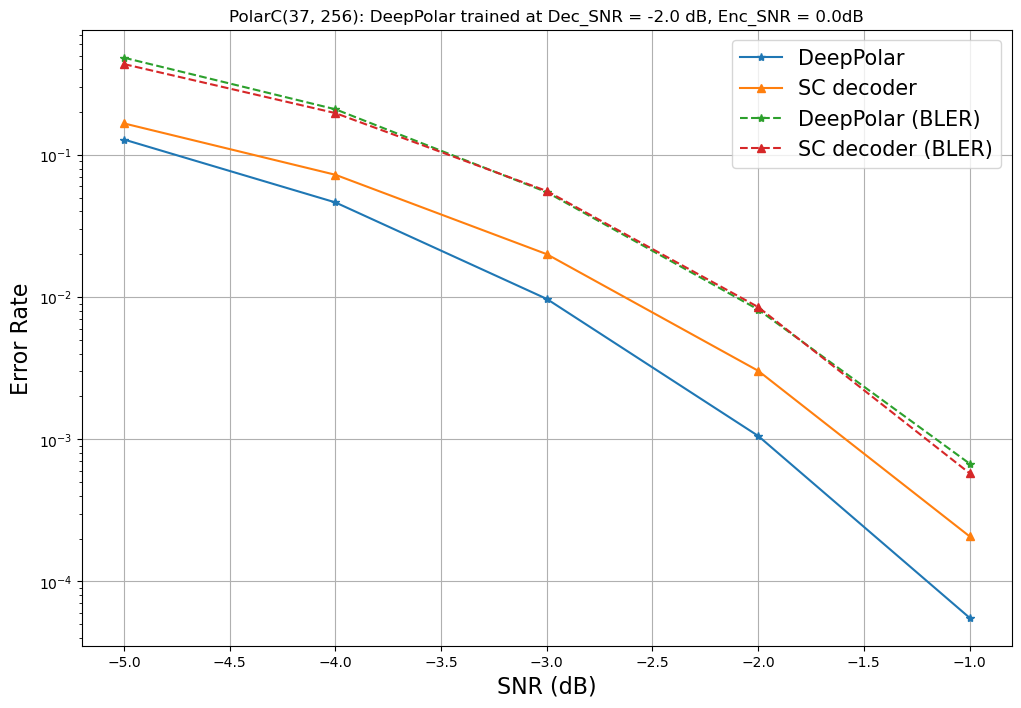

In [40]:
## BER
plt.figure(figsize = (12,8))

ok = 0
plt.semilogy(snr_range, bers_deeppolar_test, label="DeepPolar", marker='*', linewidth=1.5)

plt.semilogy(snr_range, bers_SC_test, label="SC decoder", marker='^', linewidth=1.5)

## BLER
plt.semilogy(snr_range, blers_deeppolar_test, label="DeepPolar (BLER)", marker='*', linewidth=1.5, linestyle='dashed')

plt.semilogy(snr_range, blers_SC_test, label="SC decoder (BLER)", marker='^', linewidth=1.5, linestyle='dashed')

plt.grid()
plt.xlabel("SNR (dB)", fontsize=16)
plt.ylabel("Error Rate", fontsize=16)
if enc_train_iters > 0:
    plt.title("PolarC({2}, {3}): DeepPolar trained at Dec_SNR = {0} dB, Enc_SNR = {1}dB".format(dec_train_snr, enc_train_snr, K,N))
else:
    plt.title("Polar({1}, {2}): DeepPolar trained at Dec_SNR = {0} dB".format(dec_train_snr, K,N))
plt.legend(prop={'size': 15})
if test_load_path is not None:
    os.makedirs('Polar_Results/figures', exist_ok=True)
    fig_save_path = 'Polar_Results/figures/new_plot_DeepPolar.pdf'
else:
    fig_save_path = results_load_path + f"/Step_{model_iters if model_iters is not None else 'final'}{'_binary' if binary else ''}.pdf"
if not no_fig:
    plt.savefig(fig_save_path)

plt.show()